<a href="https://colab.research.google.com/github/cds-swinburne/Synergistic-Eigenanalysis-Covariance-Hessian/blob/main/Combined_power_on_Neural_Spike_Train_dataset.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Exploring the Combined Power of Hessian and Covariance Matrices Eigenanalysis for Binary Classification on <font color=#FF5F1F>the Neural Spike Train dataset</font>


Covariance and Hessian matrices have been analyzed separately in the
literature for classification problems. However, integrating these matrices
has the potential to enhance their combined power in improving classification
performance. In this work, we present a novel approach that combines
the eigenanalysis of a covariance matrix evaluated on a training set with
a Hessian matrix evaluated on a deep learning model to achieve optimal
class separability in binary classification tasks. Our approach is formally
proven to approximately minimize within-class variances and maximize
between-class mean distance. By projecting data into the combined space
of the most relevant eigendirections from both matrices, we achieve optimal
class separability as per the LDA criterion. Empirical experiments
using <b><font color=#FF5F1F> the neural spike train data </font></b> confirm the effectiveness of our approach,
which outperforms UMAP in terms of generalization and LDA in terms of
dimensionality. This analysis further reveals that while frequency-domain
features are known to play a critical role in discriminating between the spike
train classes, the most influential parameter highlights the significance of
capturing differences or changes in activity rather than relying solely on
frequency-based characteristics. The fact that the Hessian is computed
from a deep-learning model suggests that our approach can shed light on
the underlying mechanisms of black-box models. Our approach offers an
alternative tool for interpreting binary classifiers that can potentially be
extended to multi-class problems.


In [ ]:
# Import 3rd party dependencies

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import math
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import RandomOverSampler
from imblearn.metrics import geometric_mean_score
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, cohen_kappa_score
from sklearn.metrics import (
    balanced_accuracy_score,
    accuracy_score,
    confusion_matrix,
    precision_score,
    recall_score,
)
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import RandomOverSampler
from imblearn.metrics import geometric_mean_score
from sklearn.metrics import roc_auc_score, cohen_kappa_score
from sklearn.metrics import (
    balanced_accuracy_score,
    accuracy_score,
    confusion_matrix,
    precision_score,
    recall_score,
    f1_score,
)
from imblearn.over_sampling import SMOTE
from torch.autograd.functional import hessian
from sklearn.svm import LinearSVC
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    roc_auc_score,
    cohen_kappa_score,
    confusion_matrix,
)
from sklearn.decomposition import KernelPCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.svm import SVC
!pip install umap-learn
import umap.umap_ as umap
!pip install pyDML
from dml import KDA
!pip install lolP
from lol import LOL
from sklearn.manifold import TSNE
from sklearn.manifold import LocallyLinearEmbedding
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV
import warnings
from IPython.display import display, HTML

In [ ]:
# Suppressing Warnings and Adjusting Display Width
# We ignore any warning messages that might arise during execution to maintain clean output.
# Additionally, we adjust the display width to ensure that the content is fully visible within the Jupyter notebook.

warnings.filterwarnings("ignore")
display(HTML("<style>.container { width:100% !important; }</style>"))

## Load the data, exploratory data analysis, and data splitting

In this demo we will use <b><font color=#FF5F1F> the neural spike train data </font></b>.

A spike train is a sequence of action potentials (spikes) emitted by a neuron over
time. The neural spike train dataset used in this research consists of recordings
from rat’s neurons during drug application from a multi-electrode array \[Tsai et al.
(2015); Heuschkel et al. (2002)\]. The data, comprising 221 records, represents
the final dataset after all preprocessing steps. Each record contains 15 predictor
attributes and 1 class attribute indicating whether the neuron is non-positive
(0) or positive (1).

Exploratory data analysis revealed an imbalance in the dataset, with 190 nonpositive
neurons (86%) and 31 positive neurons (14%). To preprocess the
spike train data suggested by Lazarevich et al. (2023), spike count (SC) measures
were used to encode the baseline and response spike trains. Log normalization
and z-score normalization techniques were applied for normalization. Feature
extraction was performed using the ‘tsfresh‘ package \[Christ et al. (2018)\] in
Python, resulting in the derivation of 782 features representing SCs as time
series. Differential response patterns between baseline and response periods were
captured by subtracting the corresponding baseline features to obtain response
features. Dimensionality reduction techniques were then applied, reducing
the feature set from 782 to 15 predictor attributes, where the value "15" was
arbitrarily chosen for the purpose of dimensionality reduction and not optimized.

In [ ]:
# Load the data
!wget -O "sp_train_responsiveness_(preprocessed).csv" "https://drive.google.com/uc?export=download&id=1Azd0WfH1eYFPJNHz2yCuZ-P2q3kHeEaw"
dataset_df = pd.read_csv("sp_train_responsiveness_(preprocessed).csv")

--2023-11-16 16:50:28--  https://drive.google.com/uc?export=download&id=1Azd0WfH1eYFPJNHz2yCuZ-P2q3kHeEaw
Resolving drive.google.com (drive.google.com)... 74.125.197.113, 74.125.197.101, 74.125.197.138, ...
Connecting to drive.google.com (drive.google.com)|74.125.197.113|:443... connected.
HTTP request sent, awaiting response... 303 See Other
Location: https://doc-14-0o-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/2e8bs3jch42i4sgjqn5veu8u27qukt4r/1700153400000/00672545188986181853/*/1Azd0WfH1eYFPJNHz2yCuZ-P2q3kHeEaw?e=download&uuid=ffc00b54-055a-4d4f-a481-9dff08207ea3 [following]
--2023-11-16 16:50:29--  https://doc-14-0o-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/2e8bs3jch42i4sgjqn5veu8u27qukt4r/1700153400000/00672545188986181853/*/1Azd0WfH1eYFPJNHz2yCuZ-P2q3kHeEaw?e=download&uuid=ffc00b54-055a-4d4f-a481-9dff08207ea3
Resolving doc-14-0o-docs.googleusercontent.com (doc-14-0o-docs.googleusercontent.com)... 173.194.203.132, 2607

In [ ]:
# Print the data table
dataset_df

,d_spkt_welch_density__coeff_8,"d_fft_coefficient__attr_""real""__coeff_6","d_fft_coefficient__attr_""real""__coeff_15","d_fft_coefficient__attr_""real""__coeff_18","d_fft_coefficient__attr_""real""__coeff_25","d_fft_coefficient__attr_""real""__coeff_32","d_fft_coefficient__attr_""real""__coeff_38","d_fft_coefficient__attr_""imag""__coeff_12","d_fft_coefficient__attr_""imag""__coeff_27","d_fft_coefficient__attr_""imag""__coeff_30","d_fft_coefficient__attr_""abs""__coeff_1","d_fft_coefficient__attr_""abs""__coeff_13","d_fft_coefficient__attr_""abs""__coeff_45",d_value_count__value_0,d_number_crossing_m__m_0,class
0,-0.464561,1.713729,2.294402,-0.090832,0.076006,0.688695,0.465826,1.016219,-0.609774,-0.240831,2.066137,0.160842,-0.104246,0.630848,-0.383951,1.0
1,-0.173443,2.273573,0.319179,-1.154617,1.547498,0.110913,1.037974,-1.020755,0.312202,0.215301,1.511787,-1.086690,0.819600,0.331989,-0.756816,1.0
2,1.273799,1.856653,-1.058200,-0.240451,0.245550,-0.672383,-2.451265,2.212185,-1.127752,-0.293503,2.066137,1.821971,1.640222,0.630848,-0.117620,1.0
3,2.259582,-1.163020,-1.958868,-1.107179,-0.210508,-0.155766,-0.141578,0.138081,-2.700286,-1.928375,2.066137,1.029637,2.318216,0.630848,-1.076414,1.0
4,2.259582,-0.614764,1.362632,0.814125,0.814727,1.452188,0.373495,-0.094436,0.642704,0.535789,0.263474,0.016455,-0.291620,0.331989,-0.383951,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
216,-0.459998,-0.490364,-0.882353,2.202894,-1.367011,-0.083519,-0.462709,-0.680405,0.317166,-1.340135,-0.387444,0.645102,2.143578,0.630848,0.628109,0.0
217,-0.444492,-0.967459,-0.803066,-0.700489,-0.111128,-0.075355,-0.570893,0.340835,-1.346027,1.355917,0.945672,-0.820375,-1.776154,-1.610589,-1.502545,0.0
218,-0.530635,1.168725,-1.317038,0.756954,2.366882,-1.589232,0.294676,0.017229,0.812180,-2.099895,-1.637120,-0.202333,-0.702089,-0.265727,1.427104,0.0
219,0.685906,-0.515285,-1.913814,0.184506,0.189682,0.703436,1.091319,-1.385016,0.458463,2.253475,0.149635,1.142801,-0.003354,0.630848,-0.064353,0.0


In [ ]:
attribute_names = dataset_df.columns.tolist()
attribute_names

['d_spkt_welch_density__coeff_8',
 'd_fft_coefficient__attr_"real"__coeff_6',
 'd_fft_coefficient__attr_"real"__coeff_15',
 'd_fft_coefficient__attr_"real"__coeff_18',
 'd_fft_coefficient__attr_"real"__coeff_25',
 'd_fft_coefficient__attr_"real"__coeff_32',
 'd_fft_coefficient__attr_"real"__coeff_38',
 'd_fft_coefficient__attr_"imag"__coeff_12',
 'd_fft_coefficient__attr_"imag"__coeff_27',
 'd_fft_coefficient__attr_"imag"__coeff_30',
 'd_fft_coefficient__attr_"abs"__coeff_1',
 'd_fft_coefficient__attr_"abs"__coeff_13',
 'd_fft_coefficient__attr_"abs"__coeff_45',
 'd_value_count__value_0',
 'd_number_crossing_m__m_0',
 'class']

In [ ]:
dataset_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 221 entries, 0 to 220
Data columns (total 16 columns):
 #   Column                                    Non-Null Count  Dtype  
---  ------                                    --------------  -----  
 0   d_spkt_welch_density__coeff_8             221 non-null    float64
 1   d_fft_coefficient__attr_"real"__coeff_6   221 non-null    float64
 2   d_fft_coefficient__attr_"real"__coeff_15  221 non-null    float64
 3   d_fft_coefficient__attr_"real"__coeff_18  221 non-null    float64
 4   d_fft_coefficient__attr_"real"__coeff_25  221 non-null    float64
 5   d_fft_coefficient__attr_"real"__coeff_32  221 non-null    float64
 6   d_fft_coefficient__attr_"real"__coeff_38  221 non-null    float64
 7   d_fft_coefficient__attr_"imag"__coeff_12  221 non-null    float64
 8   d_fft_coefficient__attr_"imag"__coeff_27  221 non-null    float64
 9   d_fft_coefficient__attr_"imag"__coeff_30  221 non-null    float64
 10  d_fft_coefficient__attr_"abs"__coeff_1

In [ ]:
# Generate descriptive statistics for the dataset

dataset_df.describe()

,d_spkt_welch_density__coeff_8,"d_fft_coefficient__attr_""real""__coeff_6","d_fft_coefficient__attr_""real""__coeff_15","d_fft_coefficient__attr_""real""__coeff_18","d_fft_coefficient__attr_""real""__coeff_25","d_fft_coefficient__attr_""real""__coeff_32","d_fft_coefficient__attr_""real""__coeff_38","d_fft_coefficient__attr_""imag""__coeff_12","d_fft_coefficient__attr_""imag""__coeff_27","d_fft_coefficient__attr_""imag""__coeff_30","d_fft_coefficient__attr_""abs""__coeff_1","d_fft_coefficient__attr_""abs""__coeff_13","d_fft_coefficient__attr_""abs""__coeff_45",d_value_count__value_0,d_number_crossing_m__m_0,class
count,2.210000e+02,2.210000e+02,2.210000e+02,2.210000e+02,2.210000e+02,2.210000e+02,2.210000e+02,2.210000e+02,2.210000e+02,2.210000e+02,2.210000e+02,2.210000e+02,2.210000e+02,2.210000e+02,2.210000e+02,221.000000
mean,1.286050e-16,7.234032e-17,4.521270e-18,1.607563e-17,-3.215126e-17,6.229306e-17,5.425524e-17,-4.018907e-17,8.037814e-18,-6.430251e-17,6.430251e-17,-3.777772e-16,-2.411344e-16,-4.822688e-17,-1.607563e-17,0.140271
std,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,0.348057
min,-2.437145e+00,-2.420635e+00,-2.476396e+00,-2.811586e+00,-2.411368e+00,-2.753867e+00,-2.451265e+00,-2.597296e+00,-2.700286e+00,-2.565179e+00,-2.269442e+00,-2.397173e+00,-2.380203e+00,-1.984161e+00,-2.354806e+00,0.000000
25%,-6.758721e-01,-6.147641e-01,-6.620132e-01,-7.169832e-01,-6.195242e-01,-6.781166e-01,-6.244035e-01,-6.597684e-01,-6.728637e-01,-6.582267e-01,-6.436000e-01,-6.809075e-01,-6.182960e-01,-4.151559e-01,-8.100822e-01,0.000000
50%,-3.264160e-01,-8.552010e-02,-3.650704e-02,5.010188e-02,-9.079212e-02,5.706526e-02,-4.812487e-02,-3.641091e-02,1.318516e-01,-2.391147e-02,-2.062863e-01,-1.543347e-01,-8.282495e-02,6.308477e-01,9.544557e-02,0.000000
75%,4.983095e-01,5.891496e-01,6.718665e-01,6.834869e-01,5.750382e-01,7.057168e-01,5.935040e-01,6.319170e-01,6.787510e-01,6.130748e-01,4.402947e-01,4.632695e-01,5.563087e-01,6.308477e-01,8.411743e-01,0.000000
max,2.259582e+00,2.395020e+00,2.672686e+00,2.784192e+00,2.366882e+00,2.781467e+00,2.420365e+00,2.569445e+00,2.706173e+00,2.520027e+00,2.066137e+00,2.179535e+00,2.318216e+00,6.308477e-01,2.172833e+00,1.000000


In [ ]:
# Create a column index map for predictor attributes
# The predictor_columns list contains all column names except for the "class" column,
# which corresponds to the target variable. We create a column_index_map dictionary
# to associate each predictor attribute with its corresponding index (column number).
# This mapping will be useful for further data manipulation and model building.

predictor_columns = [col for col in dataset_df.columns if col != "class"]
column_index_map = {}
for i, col_name in enumerate(predictor_columns):
    column_index_map[i] = col_name

In [ ]:
# Split dataset into training and test sets
train_df, test_df = train_test_split(dataset_df, test_size=0.2, random_state=42)

# Separate target variable from features
train_y = train_df["class"]
train_X = train_df.drop("class", axis=1)
y_test = test_df["class"]
X_test = test_df.drop("class", axis=1)

## Covariance matrix and its eigenanalysis

The equation for the covariance matrix:

$$\text{Cov}(\theta_1, \theta_2) = \frac{1}{n-1} \sum_{i=1}^{n} (\theta_{1i} - \bar{\theta}_1)(\theta_{2i} - \bar{\theta}_2)$$

where $ \theta_1 $ and $ \theta_2 $ are random variables, $ \theta_{1i} $ and $ \theta_{2i} $ are the corresponding observations, $ \bar{\theta}_1 $ and $ \bar{\theta}_2 $ are the sample means, and $ n $ is the number of observations. This equation calculates the covariance between two random variables $ \theta_1 $ and $ \theta_2 $ by taking the average of the product of their deviations from their respective means.

By performing eigenanalysis on the covariance matrix, we can obtain the eigenvalues and eigenvectors. The eigenvectors represent the principal directions or axes of the parameter space, while the eigenvalues correspond to the variances of the parameters along those directions. The eigenvector associated with the largest eigenvalue represents the leading parameter direction with the highest variance.

In [ ]:
# Calculating the covariance matrix
covariance_matrix = train_X.cov()

#### <font color=#FF5F1F><b>Figure A</b></font>

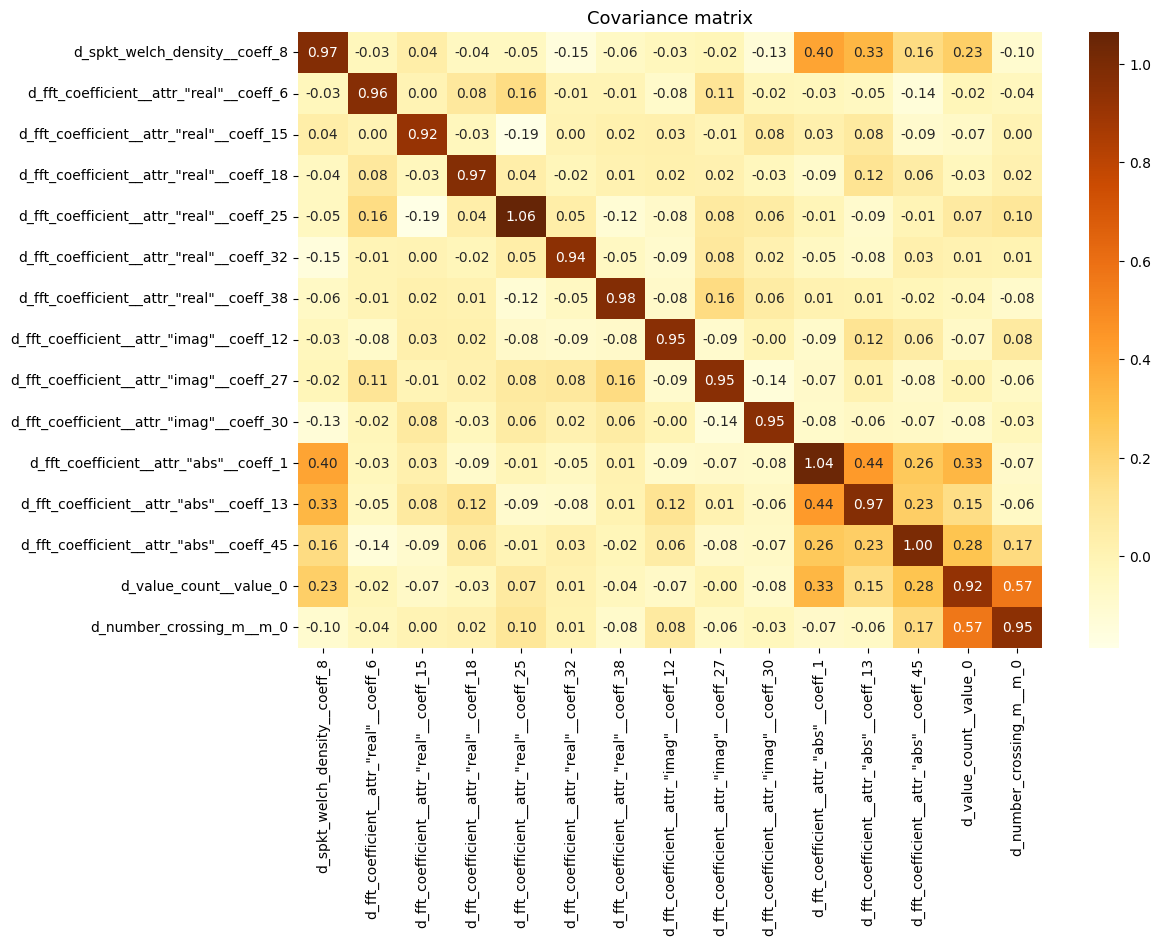

In [ ]:
# Visualize the covariance matrix as a heatmap
plt.rcParams.update({'font.size': 10})
plt.figure(figsize=(12, 8))
sns.heatmap(covariance_matrix, annot=True, cmap='YlOrBr', fmt='.2f')
plt.title('Covariance matrix', fontsize=13)
plt.show()


In [ ]:
# Perform eigenanalysis on the covariance matrix
C_eigenvalues, C_eigenvectors = np.linalg.eig(covariance_matrix)

In [ ]:
# Sort covariance eigenvalues and corresponding eigenvectors in descending order
# The 'C_eigenvalues_sorted' array contains the eigenvalues sorted in descending order,
# while the 'C_eigenvectors_sorted' array contains the corresponding eigenvectors with the same sorting.

sorted_indices = np.argsort(C_eigenvalues)[::-1]
C_eigenvalues_sorted = C_eigenvalues[sorted_indices]
C_eigenvectors_sorted = C_eigenvectors[:, sorted_indices]

## Hessian matrix and its eigenanalysis

Our Hessian matrix is evaluated on a deep learning model trained on the same training set. The expected Hessian matrix is given by:

$$\mathrm{H}_\theta = - \frac{1}{n} \sum_{i=1}^n \left[\nabla_\theta^2 \log p_\theta(c_i \mid x_i) \right]$$

The Hessian matrix provides information about the curvature and landscape of the loss function with respect to the model parameters. Eigenanalysis of the Hessian matrix allows us to extract the most discriminative directions that separate different classes.

### Deep learning model training and evaluation

We employ a deep neural network architecture consisting of four fully connected layers, each followed by a Rectified Linear Unit (ReLU) activation. The final layer employs a sigmoid activation function to yield a probability value within the range of 0 to 1. During training, we utilize the binary cross-entropy loss function along with the Adam optimizer. Addressing the class imbalance issue, we resample the training dataset using the RandomOverSampler technique.

In [ ]:
# Define the neural network model
class MyModel(nn.Module):
    def __init__(self, input_dim):
        super(MyModel, self).__init__()
        self.fc1 = nn.Linear(input_dim, 32)
        self.fc2 = nn.Linear(32, 16)
        self.fc3 = nn.Linear(16, 8)
        self.fc4 = nn.Linear(8, 1)
        self.act = nn.ReLU()
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = self.act(self.fc1(x))
        x = self.act(self.fc2(x))
        x = self.act(self.fc3(x))
        x = self.sigmoid(self.fc4(x))
        return x


# Create a custom dataset class
class MyDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.tensor(X.values, dtype=torch.float32)
        self.y = torch.tensor(y.values, dtype=torch.float32)

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]


# Resample the training set using RandomOverSampler to address class imbalance
ros = RandomOverSampler(random_state=42)
X_train, y_train = ros.fit_resample(train_X, train_y)


# Set the random seed
torch.manual_seed(19)

# Create data loaders for training and test sets
train_dataset = MyDataset(X_train, y_train)
test_dataset = MyDataset(X_test, y_test)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32)

# Instantiate the model and the optimizer
model = MyModel(X_train.shape[1])
optimizer = optim.Adam(model.parameters())

# Train the model
num_epochs = 1000
criterion = nn.BCELoss()
for epoch in range(num_epochs):
    for X_batch, y_batch in train_loader:
        optimizer.zero_grad()
        y_pred = model(X_batch)
        loss = criterion(y_pred, y_batch.unsqueeze(1))
        loss.backward()
        optimizer.step()

# Evaluate the model
X_test_tensor = torch.tensor(X_test.values, dtype=torch.float32)
y_pred_proba = model(X_test_tensor).detach().numpy()
y_pred = (y_pred_proba >= 0.5).astype(int)
auc_roc = roc_auc_score(y_test, y_pred_proba)
cohen_kappa = cohen_kappa_score(y_test, y_pred)
gmean = geometric_mean_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
f1score = f1_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)

print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))
print("Precision:", precision)
print("Recall:", recall)
print("Precision:", precision)
print("F1 score:", f1score)

# Print evaluation metrics
print("AUC ROC:", auc_roc)
print("Cohen Kappa Score:", cohen_kappa)
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)
print("Geometric Mean Score:", gmean)

Confusion Matrix:
[[38  1]
 [ 0  6]]
Precision: 0.8571428571428571
Recall: 1.0
Precision: 0.8571428571428571
F1 score: 0.923076923076923
AUC ROC: 0.9914529914529915
Cohen Kappa Score: 0.9101796407185628
Accuracy: 0.9777777777777777
Geometric Mean Score: 0.9870962335856491


In [ ]:
# Set the model to evaluation mode
model.eval()

# Compute the average Hessian matrix
hessian_sum = None
for i in range(len(train_X)):
    x = torch.tensor(train_X.iloc[i].values, dtype=torch.float32)
    y = torch.tensor([train_y.iloc[i]], dtype=torch.float32)

    hessian_matrix = hessian(lambda inputs: criterion(model(inputs), y), x)

    if hessian_sum is None:
        hessian_sum = hessian_matrix
    else:
        hessian_sum += hessian_matrix

hessian_matrix_avg = hessian_sum / len(train_X)

#### <font color=#FF5F1F><b>Figure B</b></font>

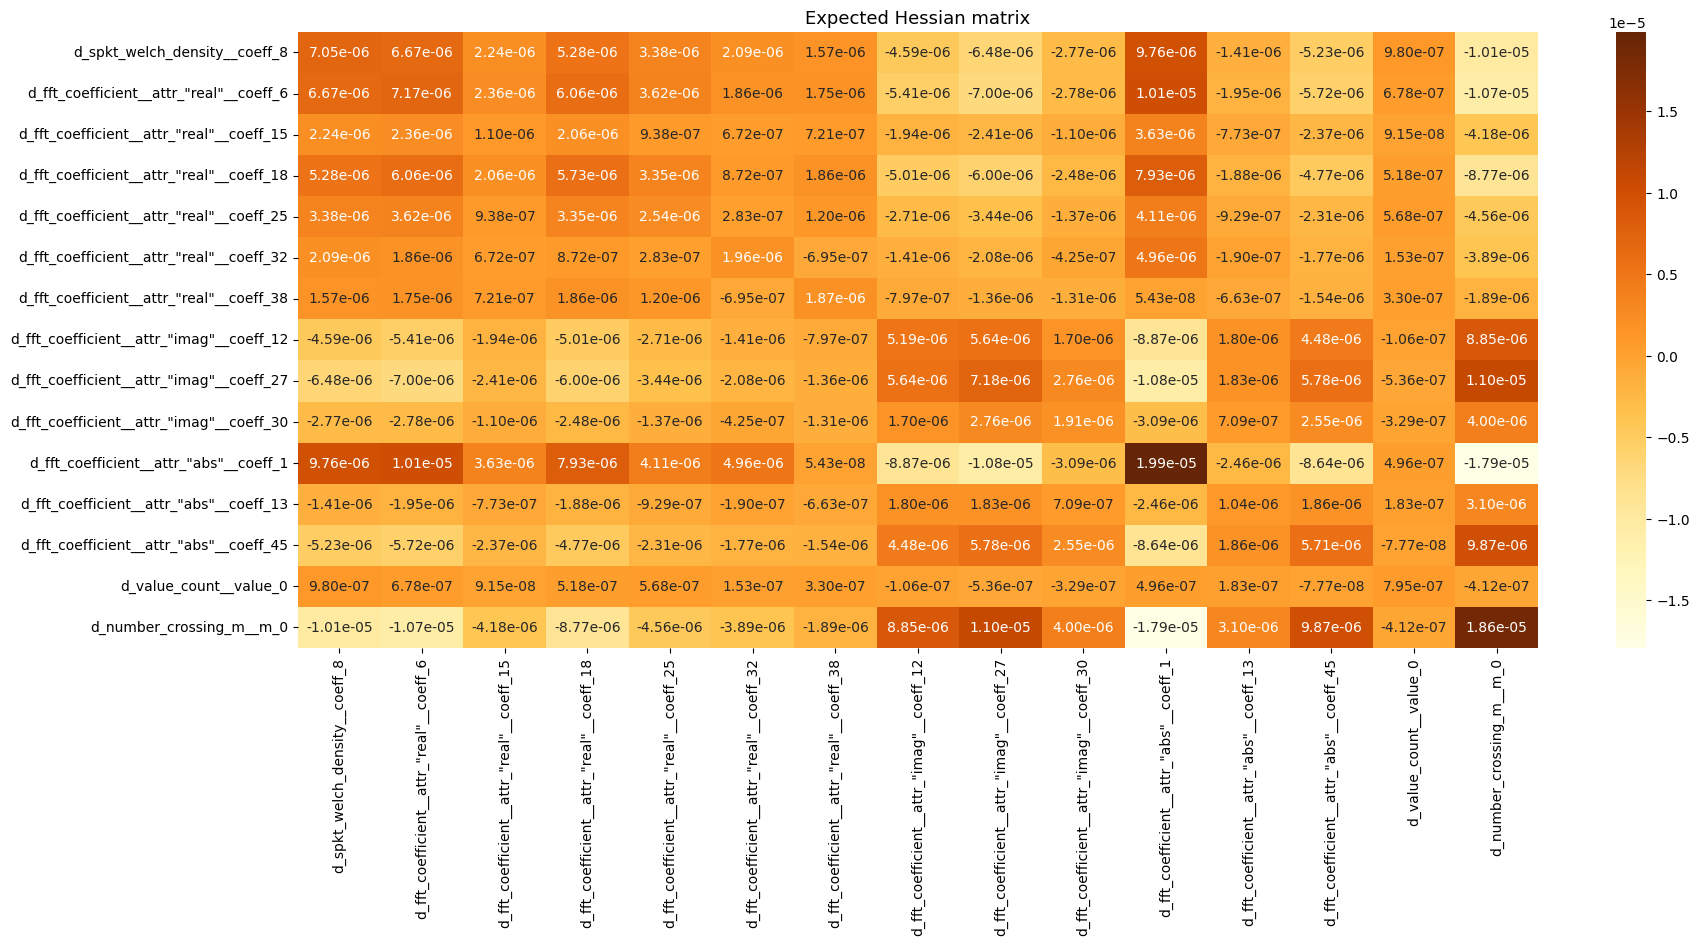

In [ ]:
# Visualize the Hessian matrix as a heatmap
plt.figure(figsize=(20, 8))
ax = sns.heatmap(hessian_matrix_avg, annot=True, cmap="YlOrBr", fmt='.2e')

# Set x-axis and y-axis tick labels using column_index_map
attribute_names = [column_index_map[i] for i in range(len(column_index_map))]
ax.set_xticklabels(attribute_names, rotation=90)
ax.set_yticklabels(attribute_names, rotation=0)

plt.title('Expected Hessian matrix', fontsize=13)
plt.show()



In [ ]:
# Perform eigenanalysis on the Hessian matrix

H = hessian_matrix_avg.numpy()
H_eigenvalues, H_eigenvectors = np.linalg.eig(H)
H_eigenvectors = np.real(H_eigenvectors)

In [ ]:
# Sort Hessian eigenvalues and corresponding eigenvectors in descending order
# The 'H_eigenvalues_sorted' array contains the Hessian eigenvalues sorted in descending order,
# while the 'H_eigenvectors_sorted' array contains the corresponding Hessian eigenvectors with the same sorting.

sorted_indices = np.argsort(H_eigenvalues)[::-1]
H_eigenvalues_sorted = H_eigenvalues[sorted_indices]
H_eigenvectors_sorted = H_eigenvectors[:, sorted_indices]

### The contribution of the parameters to the first Hessian eigenvector

The horizontal bar plot will illustrate the relative importance of each parameter in influencing the first eigenvector of the Hessian matrix. Parameters with higher contributions have a greater impact on the first eigenvector and play a crucial role in distinguishing different classes within the dataset.

#### <font color=#FF5F1F><b>Figure C</b></font>

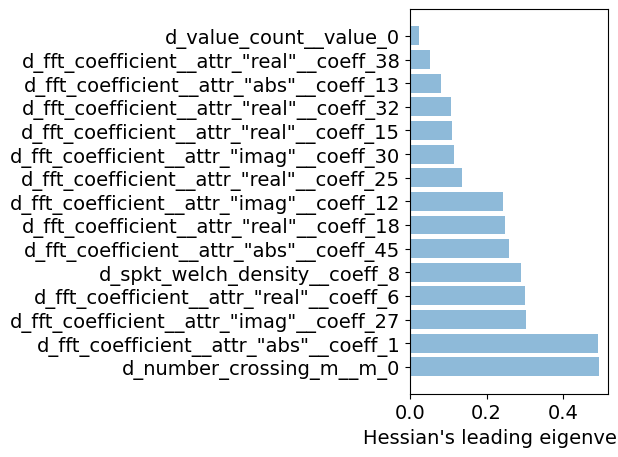

In [ ]:
# Calculate the absolute values of the elements in the first eigenvector of the Hessian matrix
H_first_eigenvector = abs(H_eigenvectors_sorted[:, 0])

# Define parameter names
param_names = [column_index_map[i] for i in range(15)]


# Sort the parameters by their absolute contributions
sorted_indices = np.argsort(np.abs(H_first_eigenvector))[::-1]
sorted_param_names = [param_names[i] for i in sorted_indices]
sorted_contributions = H_first_eigenvector[sorted_indices]

# Create a horizontal bar plot
y_pos = np.arange(len(sorted_param_names))
plt.barh(y_pos, sorted_contributions, align="center", alpha=0.5)
plt.yticks(y_pos, sorted_param_names)
plt.xlabel("Hessian's leading eigenvector")

# Display the plot
plt.tight_layout()
plt.show()

## Projection of data using Hessian and covariance eigenvectors

We project data into the combined space of eigendirections from the covariance and Hessian matrices.

### Selected 9 out of 225 projected data plots, each representing the combined space of Hessian and covariance eigenvectors

#### <font color=#FF5F1F><b>Figure D</b></font>

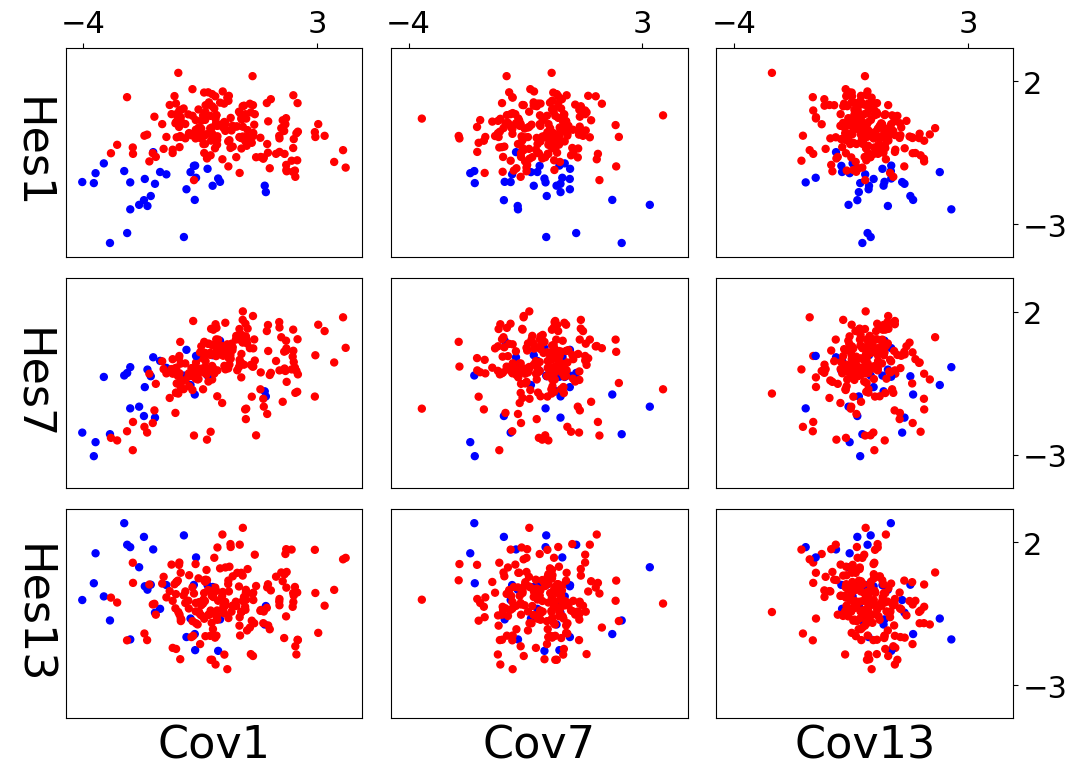

In [ ]:
# Compute 30-dimensional projections using Hessian eigenvectors
H_proj = np.dot(dataset_df.drop("class", axis=1), H_eigenvectors_sorted[:, :15])
H_proj = H_proj / H_proj.std(axis=0)  # Standardize the projections

# Compute 30-dimensional projections using Covariance eigenvectors
C_proj = np.dot(dataset_df.drop("class", axis=1), C_eigenvectors_sorted[:, :15])

# Define colors based on class values in train_y
colors = ["red" if y == 0 else "blue" for y in dataset_df["class"]]

# Select specific eigenvectors for projection
H_proj_selected = [
      H_proj[:, 0]/ np.std(H_proj[:, 0]),
      H_proj[:, 6]/ np.std(H_proj[:, 6]),
      H_proj[:, 12]/ np.std(H_proj[:, 12]),
]

C_proj_selected = [
    C_proj[:, 0],
    C_proj[:, 6],
    C_proj[:, 12],
]

# Determine limits for the x and y axes based on selected projections
x_low_limit = min([min(C_proj[:, 0]), min(C_proj[:, 6]), min(C_proj[:, 12])])
x_up_limit = max([max(C_proj[:, 0]), max(C_proj[:, 6]), max(C_proj[:, 12])])
y_low_limit = min([min(H_proj[:, 0]), min(H_proj[:, 6]), min(H_proj[:, 12])])
y_up_limit = max([max(H_proj[:, 0]), max(H_proj[:, 6]), max(H_proj[:, 12])])

# Create a 3x3 grid of subplots
fig, axs = plt.subplots(3, 3, figsize=(11, 8))

results = []  # Store computed results for later analysis

# Loop to compute and visualize all 9 projections
for i in range(3):
    for j in range(3):
        # Compute the 2-dimensional projection using the current eigenvectors
        X_proj = np.stack((H_proj_selected[i], C_proj_selected[j]), axis=1)

        # Compute the mean of each class for Hessian projection
        mean0 = np.mean(C_proj_selected[j][dataset_df["class"] == 0], axis=0)
        mean1 = np.mean(C_proj_selected[j][dataset_df["class"] == 1], axis=0)

        m0 = np.mean(H_proj_selected[i][dataset_df["class"] == 0], axis=0)
        m1 = np.mean(H_proj_selected[i][dataset_df["class"] == 1], axis=0)

        # Compute the squared distance of inter-class means
        d2 = np.sum(np.square(mean0 - mean1))

        # Compute the variance of class 0 and class 1 for Hessian projection
        var0 = np.sum(np.square(H_proj_selected[i][dataset_df["class"] == 0] - m0)) / (
            H_proj_selected[i][dataset_df["class"] == 0].shape[0] - 1
        )
        var1 = np.sum(np.square(H_proj_selected[i][dataset_df["class"] == 1] - m1)) / (
            H_proj_selected[i][dataset_df["class"] == 1].shape[0] - 1
        )

        # Plot the projection on the corresponding subplot
        axs[i, j].scatter(C_proj_selected[j], H_proj_selected[i], c=colors, s=25)

        # Set the same x-axis limits for all subplots
        axs[i, j].set_xlim([x_low_limit-0.5, x_up_limit+0.5])

        # Set the same y-axis limits for all subplots
        axs[i, j].set_ylim([y_low_limit-0.5, y_up_limit+0.5])

        # Customize ticks and labels for better visualization
        if i > 0:
            axs[i, j].set_xticks([])
        else:
            axs[i, j].xaxis.tick_top()
            axs[i, j].set_xticks([int(x_low_limit), int(x_up_limit)])

        if j < 2:
            axs[i, j].set_yticks([])
        else:
            axs[i, j].yaxis.tick_right()
            axs[i, j].set_yticks([int(y_low_limit), int(y_up_limit)])

        # Increase the font size of ticks for clarity
        axs[i, j].tick_params(axis='both', which='both', labelsize=22)

        # Add labels for each column and row
        axs[2, j].set_xlabel(f"Cov{6*j+1}", fontsize=32, position=(0.5, -0.15))
        axs[i, 0].set_ylabel(f"Hes{6*i+1}", fontsize=32, rotation=270, labelpad=40)

        # Store the computed values for later analysis
        results.append({"projection": (i, j), "d2": d2, "var0": var0, "var1": var1})

# Ensure tight layout and display the plot
plt.tight_layout()
plt.show()


### Selected 25 out of 225 projected data plots, each representing the combined space of Hessian and covariance eigenvectors

#### <font color=#FF5F1F><b>Figure E</b></font>

In [ ]:
# Select eigenvectors for projection
H_proj_selected = [
      H_proj[:, 0]/ np.std(H_proj[:, 0]),
      H_proj[:, 3]/ np.std(H_proj[:, 3]),
      H_proj[:, 6]/ np.std(H_proj[:, 6]),
      H_proj[:, 9]/ np.std(H_proj[:, 9]),
      H_proj[:, 12]/ np.std(H_proj[:, 12]),
]
C_proj_selected = [
    C_proj[:, 0],
    C_proj[:, 3],
    C_proj[:, 6],
    C_proj[:, 9],
    C_proj[:, 12],
]

# Compute all 25 projections

results = []
for i in range(5):
    for j in range(5):
        # Compute the 2-dimensional projection using the current eigenvectors
        X_proj = np.stack((H_proj_selected[i], C_proj_selected[j]), axis=1)

        # Compute the mean of each class
        mean0 = np.mean(C_proj_selected[j][dataset_df["class"] == 0], axis=0)
        mean1 = np.mean(C_proj_selected[j][dataset_df["class"] == 1], axis=0)

        m0 = np.mean(H_proj_selected[i][dataset_df["class"] == 0], axis=0)
        m1 = np.mean(H_proj_selected[i][dataset_df["class"] == 1], axis=0)

        # Compute the squared distance of inter-class means
        d2 = np.sum(np.square(mean0 - mean1))

        # Compute the variance of class 0
        var0 = np.sum(np.square(H_proj_selected[i][dataset_df["class"] == 0] - m0)) / (
            H_proj_selected[i][dataset_df["class"] == 0].shape[0] - 1
        )

        # Compute the variance of class 1
        var1 = np.sum(np.square(H_proj_selected[i][dataset_df["class"] == 1] - m1)) / (
            H_proj_selected[i][dataset_df["class"] == 1].shape[0] - 1
        )

        # Store the computed values
        results.append({"projection": (i, j), "d2": d2, "var0": var0, "var1": var1})

### Heatmap showing the squared between-class mean distance across different covariance eigenvectors for varying combinations of Hessian and covariance eigenvectors

#### <font color=#FF5F1F><b>Figure F</b></font>

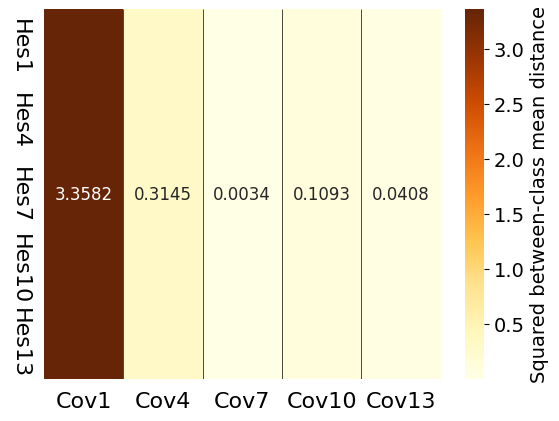

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

d2_matrix = np.array([result["d2"] for result in results]).reshape(5, 5)

plt.rcParams.update({'font.size': 14})

# Create a heatmap of the d2 matrix using seaborn
annot = np.full_like(d2_matrix, "", dtype=np.object)
annot[2, :] = np.round(d2_matrix[2, :], decimals=4).astype(str)
ax = sns.heatmap(d2_matrix, annot=annot, fmt="", cmap="YlOrBr", cbar=True, annot_kws={"fontsize": 12})

ax.set_xticks([])
ax.set_yticks([])
ax.vlines(np.arange(1, 5), *ax.get_ylim(), colors='black', linewidth=0.5)

for i in range(5):
    ax.text(i + 0.5, 5.3, f"Cov{i*3+1}", ha="center", va="center", fontsize=16)  # Set font size
for j in range(5):
    ax.text(-0.3, j + 0.5, f"Hes{j*3+1}", ha="center", va="center", rotation=270, fontsize=16)  # Set font size


# Show the color bar
cbar = ax.collections[0].colorbar
cbar.set_label("Squared between-class mean distance")
plt.show()

### Heatmap showing the sum of within-class variances across different Hessian eigenvectors and for different combinations of Hessian and covariance eigenvectors

#### <font color=#FF5F1F><b>Figure G</b></font>

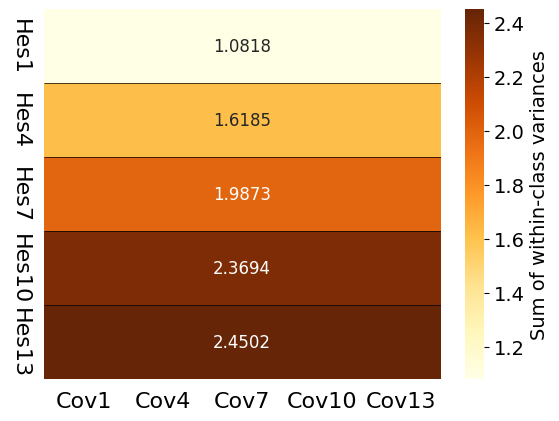

In [ ]:
var0_matrix = np.array([result["var0"] for result in results]).reshape(5, 5)
var1_matrix = np.array([result["var1"] for result in results]).reshape(5, 5)

v_matrix = var0_matrix + var1_matrix

# Create a heatmap of the d2 matrix using seaborn
ax = sns.heatmap(
    v_matrix,
    annot=np.where(
        np.arange(v_matrix.shape[0]) == 2, v_matrix.round(4).astype(str), ""
    ),
    fmt="",
    cmap="YlOrBr",
    cbar=True,
    annot_kws={"fontsize": 12}
)

ax.set_xticks([])
ax.set_yticks([])
ax.hlines(np.arange(1, 5), *ax.get_xlim(), colors='black', linewidth=0.5)

for i in range(5):
    ax.text(i + 0.5, 5.3, f"Cov{i*3+1}", ha="center", va="center", fontsize=16)  # Set font size
for j in range(5):
    ax.text(-0.3, j + 0.5, f"Hes{j*3+1}", ha="center", va="center", rotation=270, fontsize=16)  # Set font size


# Show the color bar
cbar = ax.collections[0].colorbar
cbar.set_label("Sum of within-class variances")

plt.show()

### Heatmap displaying the LDA ratio

Each value representing the ratio between the squared between-class mean distance on the covariance eigenvector projection and the corresponding within-class variances on the Hessian eigenvector projection

#### <font color=#FF5F1F><b>Figure H</b></font>

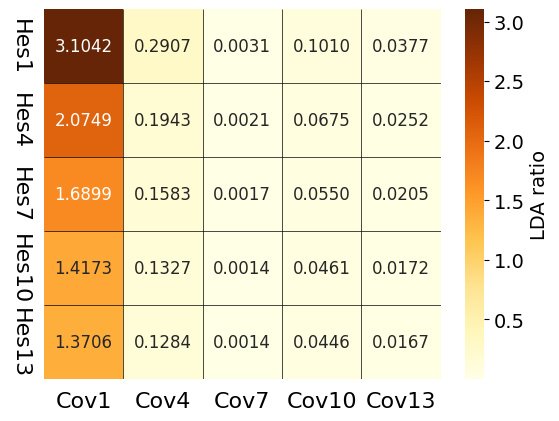

In [ ]:
c_matrix = d2_matrix / (var0_matrix + var1_matrix)

# Create a heatmap of the d2 matrix using seaborn
ax = sns.heatmap(c_matrix, annot=True, fmt=".4f", cmap="YlOrBr", cbar=True, annot_kws={"fontsize": 12})
ax.set_xticks([])
ax.set_yticks([])

# Add slope values to the right of each row and to the bottom of each column
for i in range(5):
    ax.text(i + 0.5, 5.3, f"Cov{i*3+1}", ha="center", va="center", fontsize=16)  # Set font size
for j in range(5):
    ax.text(-0.3, j + 0.5, f"Hes{j*3+1}", ha="center", va="center", rotation=270, fontsize=16)  # Set font size

# Add lines to every border
ax.vlines(np.arange(1, 5), *ax.get_ylim(), colors='black', linewidth=0.5)
ax.hlines(np.arange(1, 5), *ax.get_xlim(), colors='black', linewidth=0.5)

# Show the color bar
cbar = ax.collections[0].colorbar
cbar.set_label("LDA ratio")

plt.show()

## Holdout validation

### Proposed method

In [ ]:
# Compute 30-dimensional projections using H_eigenvectors_sorted
H_train_proj = np.dot(train_X, H_eigenvectors_sorted[:, :15])
H_train_proj = H_train_proj / H_train_proj.std(axis=0)

# Compute 30-dimensional projections using C_eigenvectors_sorted
C_train_proj = np.dot(train_X, C_eigenvectors_sorted[:, :15])

In [ ]:
# Compute 30-dimensional projections using H_eigenvectors_sorted
H_test_proj = np.dot(X_test, H_eigenvectors_sorted[:, :15])
H_test_proj = H_test_proj / H_test_proj.std(axis=0)

# Compute 30-dimensional projections using C_eigenvectors_sorted
C_test_proj = np.dot(X_test, C_eigenvectors_sorted[:, :15])

In [ ]:
# Separate features and target variable
X_train_proj = np.stack((C_train_proj[:,0], H_train_proj[:,0]), axis=1)

X_test_proj = np.stack((C_test_proj[:,0], H_test_proj[:,0]), axis=1)


# Initialize the LinearSVC classifier
classifier = LinearSVC(random_state=1)

# Train the classifier on the training set
classifier.fit(X_train_proj, train_y)

# Make predictions on the training and test sets
y_test_pred = classifier.predict(X_test_proj)


#### <font color=#FF5F1F><b>Figure I</b></font>

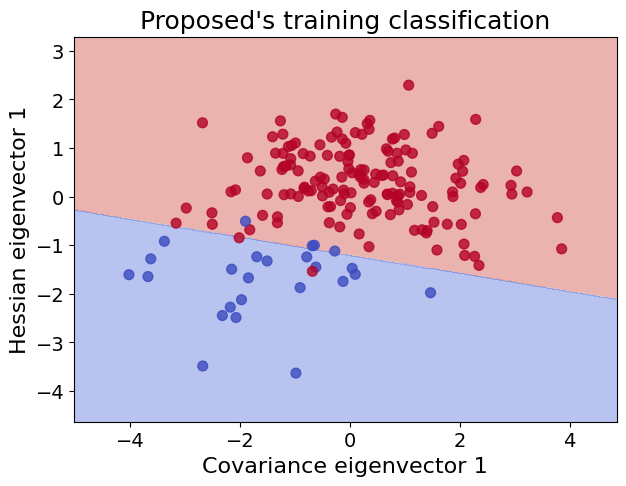

In [ ]:
X_train_proj = pd.DataFrame(X_train_proj)

# Plot the training and test sets along with the separating hyperplane
x_min, x_max = X_train_proj.iloc[:, 0].min() - 1, X_train_proj.iloc[:, 0].max() + 1
y_min, y_max = X_train_proj.iloc[:, 1].min() - 1, X_train_proj.iloc[:, 1].max() + 1
X, Y = np.meshgrid(np.arange(x_min, x_max, 0.02), np.arange(y_min, y_max, 0.02))
Z = classifier.predict(np.c_[X.ravel(), Y.ravel()])
Z = Z.reshape(X.shape)

plt.figure(figsize=(7, 5))

plt.contourf(X, Y, Z, alpha=0.4, cmap="coolwarm_r")
plt.scatter(
    X_train_proj.iloc[:, 0],
    X_train_proj.iloc[:, 1],
    c=train_y,
    alpha=0.8,
    cmap="coolwarm_r",
    s=50,
)
plt.ylabel("Hessian eigenvector 1", fontsize=16)
plt.xlabel("Covariance eigenvector 1", fontsize=16)
plt.title("Proposed's training classification", fontsize=18)
plt.show()

#### <font color=#FF5F1F><b>Figure J</b></font>

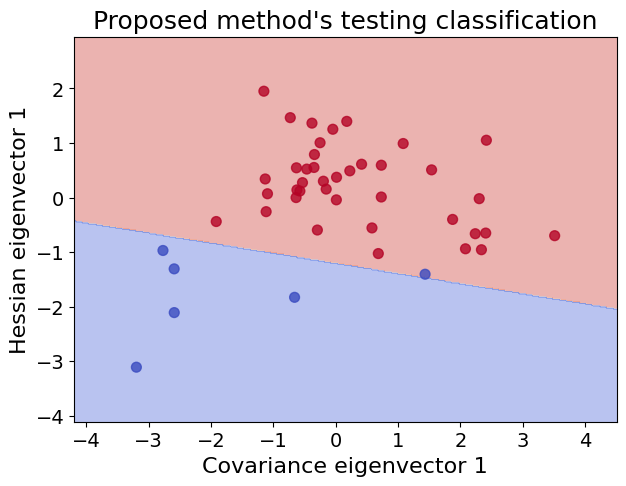

In [ ]:
X_test_proj = pd.DataFrame(X_test_proj)

# Plot the training and test sets along with the separating hyperplane
x_min, x_max = X_test_proj.iloc[:, 0].min() - 1, X_test_proj.iloc[:, 0].max() + 1
y_min, y_max = X_test_proj.iloc[:, 1].min() - 1, X_test_proj.iloc[:, 1].max() + 1
X, Y = np.meshgrid(np.arange(x_min, x_max, 0.02), np.arange(y_min, y_max, 0.02))
Z = classifier.predict(np.c_[X.ravel(), Y.ravel()])
Z = Z.reshape(X.shape)

plt.figure(figsize=(7, 5))

plt.contourf(X, Y, Z, alpha=0.4, cmap="coolwarm_r")
plt.scatter(
    X_test_proj.iloc[:, 0],
    X_test_proj.iloc[:, 1],
    c=y_test,
    alpha=0.8,
    cmap="coolwarm_r",
    s=50,
)
plt.ylabel("Hessian eigenvector 1", fontsize=16)
plt.xlabel("Covariance eigenvector 1", fontsize=16)
plt.title("Proposed method's testing classification", fontsize=18)
plt.show()

In [ ]:
# Calculate evaluation metrics for test sets

test_acc = accuracy_score(y_test, y_test_pred)
test_precision = precision_score(y_test, y_test_pred)
test_recall = recall_score(y_test, y_test_pred)
test_f1 = f1_score(y_test, y_test_pred)
test_roc_auc = roc_auc_score(y_test, y_test_pred)
test_kappa = cohen_kappa_score(y_test, y_test_pred)

proposed_eval = [
    test_precision,
    test_recall,
    test_f1,
    test_roc_auc,
    test_kappa,
]

# Print evaluation metrics for test sets

print("\nTest set metrics:")
print("Confusion Matrix:")
print(confusion_matrix(y_test.values, y_test_pred))
print("Accuracy:", test_acc)
print("Precision:", test_precision)
print("Recall:", test_recall)
print("F1 score:", test_f1)
print("ROC AUC score:", test_roc_auc)
print("Cohen's kappa score:", test_kappa)


Test set metrics:
Confusion Matrix:
[[39  0]
 [ 1  5]]
Accuracy: 0.9777777777777777
Precision: 1.0
Recall: 0.8333333333333334
F1 score: 0.9090909090909091
ROC AUC score: 0.9166666666666667
Cohen's kappa score: 0.896551724137931


### Hessian method

In [ ]:

# Separate features and target variable
X_train_proj = np.stack((H_train_proj[:,1], H_train_proj[:,0]), axis=1)

X_test_proj = np.stack((H_test_proj[:,1], H_test_proj[:,0]), axis=1)


# Initialize the LinearSVC classifier
classifier = LinearSVC(random_state=1)

# Train the classifier on the training set
classifier.fit(X_train_proj, train_y)

# Make predictions on the training and test sets
y_test_pred = classifier.predict(X_test_proj)


#### <font color=#FF5F1F><b>Figure K</b></font>

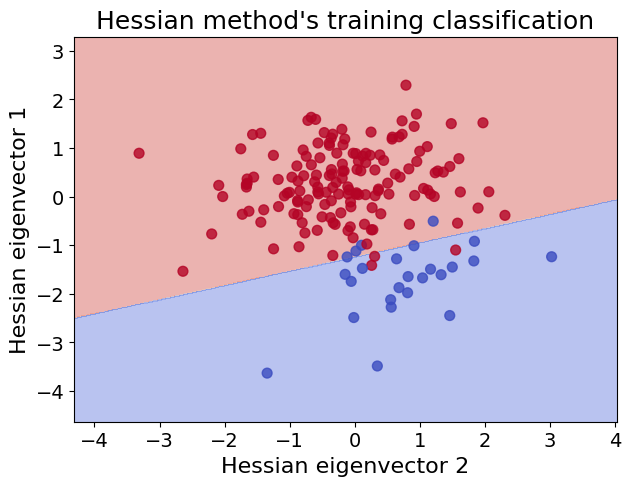

In [ ]:
X_train_proj = pd.DataFrame(X_train_proj)

# Plot the training and test sets along with the separating hyperplane
x_min, x_max = X_train_proj.iloc[:, 0].min() - 1, X_train_proj.iloc[:, 0].max() + 1
y_min, y_max = X_train_proj.iloc[:, 1].min() - 1, X_train_proj.iloc[:, 1].max() + 1
X, Y = np.meshgrid(np.arange(x_min, x_max, 0.02), np.arange(y_min, y_max, 0.02))
Z = classifier.predict(np.c_[X.ravel(), Y.ravel()])
Z = Z.reshape(X.shape)

plt.figure(figsize=(7, 5))

plt.contourf(X, Y, Z, alpha=0.4, cmap="coolwarm_r")
plt.scatter(
    X_train_proj.iloc[:, 0],
    X_train_proj.iloc[:, 1],
    c=train_y,
    alpha=0.8,
    cmap="coolwarm_r",
    s=50,
)
plt.ylabel("Hessian eigenvector 1", fontsize=16)
plt.xlabel("Hessian eigenvector 2", fontsize=16)
plt.title("Hessian method's training classification", fontsize=18)
plt.show()

#### <font color=#FF5F1F><b>Figure L</b></font>

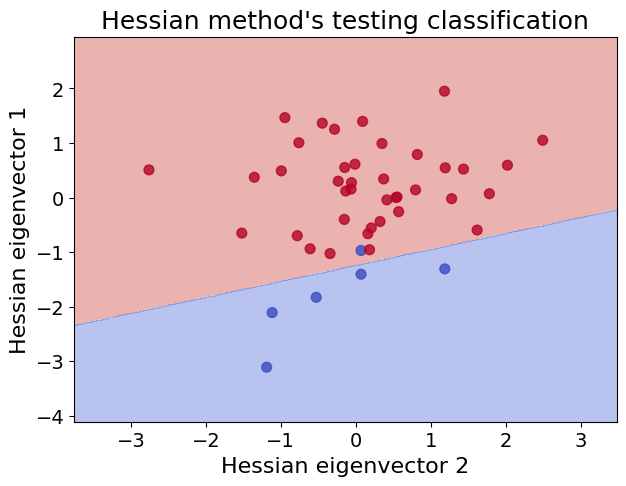

In [ ]:
X_test_proj = pd.DataFrame(X_test_proj)

# Plot the training and test sets along with the separating hyperplane
x_min, x_max = X_test_proj.iloc[:, 0].min() - 1, X_test_proj.iloc[:, 0].max() + 1
y_min, y_max = X_test_proj.iloc[:, 1].min() - 1, X_test_proj.iloc[:, 1].max() + 1
X, Y = np.meshgrid(np.arange(x_min, x_max, 0.02), np.arange(y_min, y_max, 0.02))
Z = classifier.predict(np.c_[X.ravel(), Y.ravel()])
Z = Z.reshape(X.shape)

plt.figure(figsize=(7, 5))

plt.contourf(X, Y, Z, alpha=0.4, cmap="coolwarm_r")
plt.scatter(
    X_test_proj.iloc[:, 0],
    X_test_proj.iloc[:, 1],
    c=y_test,
    alpha=0.8,
    cmap="coolwarm_r",
    s=50,
)
plt.ylabel("Hessian eigenvector 1", fontsize=16)
plt.xlabel("Hessian eigenvector 2", fontsize=16)
plt.title("Hessian method's testing classification", fontsize=18)
plt.show()

In [ ]:
# Calculate evaluation metrics for test sets

test_acc = accuracy_score(y_test, y_test_pred)
test_precision = precision_score(y_test, y_test_pred)
test_recall = recall_score(y_test, y_test_pred)
test_f1 = f1_score(y_test, y_test_pred)
test_roc_auc = roc_auc_score(y_test, y_test_pred)
test_kappa = cohen_kappa_score(y_test, y_test_pred)

hessian_eval = [
    test_precision,
    test_recall,
    test_f1,
    test_roc_auc,
    test_kappa,
]

# Print evaluation metrics for test sets

print("\nTest set metrics:")
print("Confusion Matrix:")
print(confusion_matrix(y_test.values, y_test_pred))
print("Accuracy:", test_acc)
print("Precision:", test_precision)
print("Recall:", test_recall)
print("F1 score:", test_f1)
print("ROC AUC score:", test_roc_auc)
print("Cohen's kappa score:", test_kappa)


Test set metrics:
Confusion Matrix:
[[39  0]
 [ 1  5]]
Accuracy: 0.9777777777777777
Precision: 1.0
Recall: 0.8333333333333334
F1 score: 0.9090909090909091
ROC AUC score: 0.9166666666666667
Cohen's kappa score: 0.896551724137931


### PCA

In [ ]:
# Separate features and target variable
X_train_proj = np.stack((C_train_proj[:,1], C_train_proj[:,0]), axis=1)

X_test_proj = np.stack((C_test_proj[:,1], C_test_proj[:,0]), axis=1)


# Initialize the LinearSVC classifier
classifier = LinearSVC(random_state=1)

# Train the classifier on the training set
classifier.fit(X_train_proj, train_y)

# Make predictions on the training and test sets
y_test_pred = classifier.predict(X_test_proj)


#### <font color=#FF5F1F><b>Figure M</b></font>

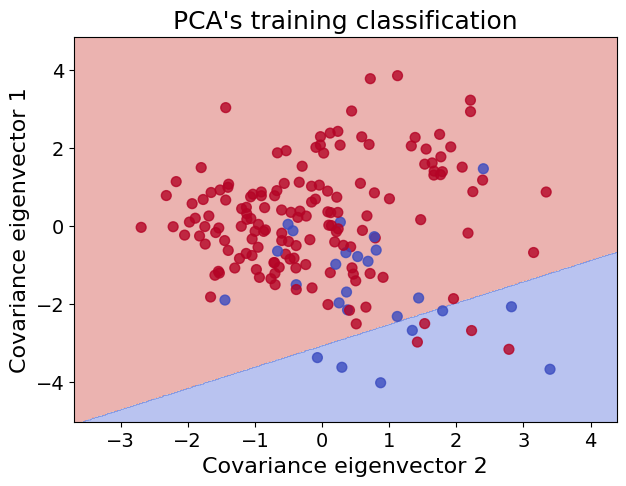

In [ ]:
X_train_proj = pd.DataFrame(X_train_proj)

# Plot the training and test sets along with the separating hyperplane
x_min, x_max = X_train_proj.iloc[:, 0].min() - 1, X_train_proj.iloc[:, 0].max() + 1
y_min, y_max = X_train_proj.iloc[:, 1].min() - 1, X_train_proj.iloc[:, 1].max() + 1
X, Y = np.meshgrid(np.arange(x_min, x_max, 0.02), np.arange(y_min, y_max, 0.02))
Z = classifier.predict(np.c_[X.ravel(), Y.ravel()])
Z = Z.reshape(X.shape)

plt.figure(figsize=(7, 5))

plt.contourf(X, Y, Z, alpha=0.4, cmap="coolwarm_r")
plt.scatter(
    X_train_proj.iloc[:, 0],
    X_train_proj.iloc[:, 1],
    c=train_y,
    alpha=0.8,
    cmap="coolwarm_r",
    s=50,
)
plt.ylabel("Covariance eigenvector 1", fontsize=16)
plt.xlabel("Covariance eigenvector 2", fontsize=16)
plt.title("PCA's training classification", fontsize=18)
plt.show()

#### <font color=#FF5F1F><b>Figure N</b></font>

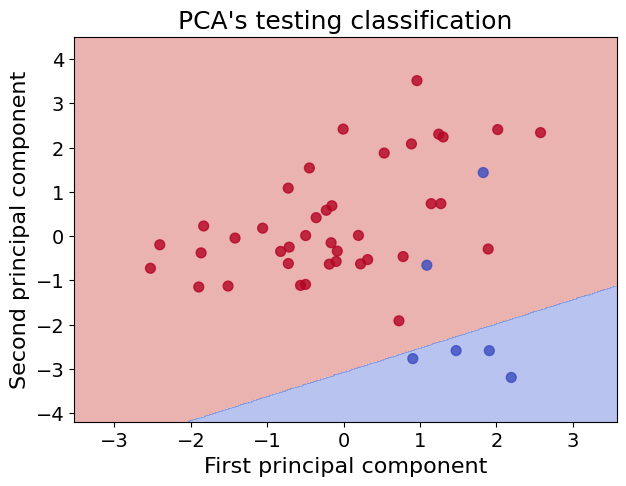

In [ ]:
X_test_proj = pd.DataFrame(X_test_proj)

# Plot the training and test sets along with the separating hyperplane
x_min, x_max = X_test_proj.iloc[:, 0].min() - 1, X_test_proj.iloc[:, 0].max() + 1
y_min, y_max = X_test_proj.iloc[:, 1].min() - 1, X_test_proj.iloc[:, 1].max() + 1
X, Y = np.meshgrid(np.arange(x_min, x_max, 0.02), np.arange(y_min, y_max, 0.02))
Z = classifier.predict(np.c_[X.ravel(), Y.ravel()])
Z = Z.reshape(X.shape)

plt.figure(figsize=(7, 5))

plt.contourf(X, Y, Z, alpha=0.4, cmap="coolwarm_r")
plt.scatter(
    X_test_proj.iloc[:, 0],
    X_test_proj.iloc[:, 1],
    c=y_test,
    alpha=0.8,
    cmap="coolwarm_r",
    s=50,
)
plt.ylabel("Second principal component", fontsize=16)
plt.xlabel("First principal component", fontsize=16)
plt.title("PCA's testing classification", fontsize=18)
plt.show()

In [ ]:
# Calculate evaluation metrics for test sets

test_acc = accuracy_score(y_test, y_test_pred)
test_precision = precision_score(y_test, y_test_pred)
test_recall = recall_score(y_test, y_test_pred)
test_f1 = f1_score(y_test, y_test_pred)
test_roc_auc = roc_auc_score(y_test, y_test_pred)
test_kappa = cohen_kappa_score(y_test, y_test_pred)

cov_eval = [
    test_precision,
    test_recall,
    test_f1,
    test_roc_auc,
    test_kappa,
]

# Print evaluation metrics for test sets

print("\nTest set metrics:")
print("Confusion Matrix:")
print(confusion_matrix(y_test.values, y_test_pred))
print("Accuracy:", test_acc)
print("Precision:", test_precision)
print("Recall:", test_recall)
print("F1 score:", test_f1)
print("ROC AUC score:", test_roc_auc)
print("Cohen's kappa score:", test_kappa)


Test set metrics:
Confusion Matrix:
[[39  0]
 [ 2  4]]
Accuracy: 0.9555555555555556
Precision: 1.0
Recall: 0.6666666666666666
F1 score: 0.8
ROC AUC score: 0.8333333333333333
Cohen's kappa score: 0.7761194029850746


### UMAP

In [ ]:
# Define the target variable and the features
target = train_y
features = train_X

# Create a supervised UMAP object
umap_supervised = umap.UMAP(
    n_neighbors=20, n_components=2, metric="euclidean", random_state=23
)

# Fit the UMAP model with the features and target variable
embedding = umap_supervised.fit_transform(features, y=target)

In [ ]:
# Separate features and target variable
X_train_umap = pd.DataFrame(embedding)
y_train_umap = target

X_test_umap = umap_supervised.transform(X_test)


# Initialize the LinearSVC classifier
classifier = LinearSVC(random_state=1)

# Train the classifier on the training set
classifier.fit(X_train_umap, target)

# Make predictions on the training and test sets
y_test_pred = classifier.predict(X_test_umap)

#### <font color=#FF5F1F><b>Figure O</b></font>

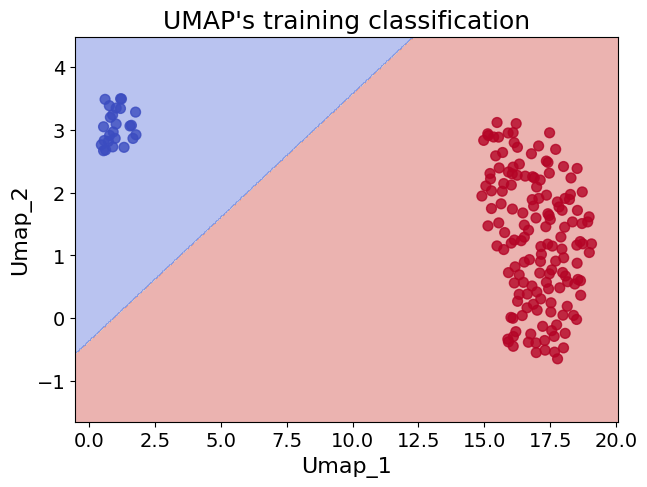

In [ ]:
X_train_proj = X_train_umap

# Plot the training and test sets along with the separating hyperplane
x_min, x_max = X_train_proj.iloc[:, 0].min() - 1, X_train_proj.iloc[:, 0].max() + 1
y_min, y_max = X_train_proj.iloc[:, 1].min() - 1, X_train_proj.iloc[:, 1].max() + 1
X, Y = np.meshgrid(np.arange(x_min, x_max, 0.02), np.arange(y_min, y_max, 0.02))
Z = classifier.predict(np.c_[X.ravel(), Y.ravel()])
Z = Z.reshape(X.shape)

plt.figure(figsize=(7, 5))

plt.contourf(X, Y, Z, alpha=0.4, cmap="coolwarm_r")
plt.scatter(
    X_train_proj.iloc[:, 0],
    X_train_proj.iloc[:, 1],
    c=y_train_umap,
    alpha=0.8,
    cmap="coolwarm_r",
    s=50,
)
plt.xlabel("Umap_1", fontsize=16)
plt.ylabel("Umap_2", fontsize=16)
plt.title("UMAP's training classification", fontsize=18)
plt.show()

#### <font color=#FF5F1F><b>Figure P</b></font>

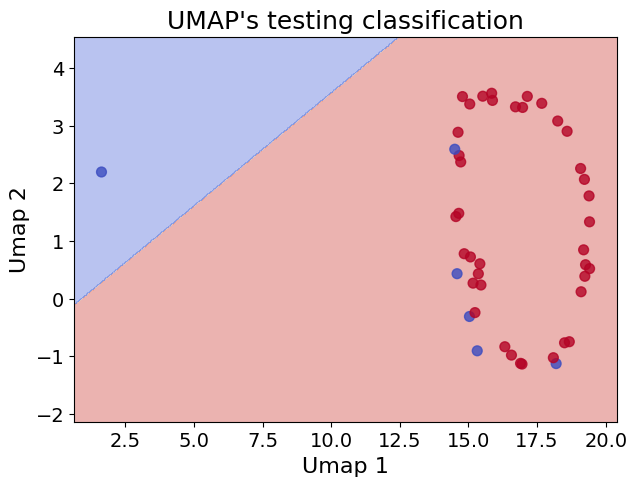

In [ ]:
X_test_proj = pd.DataFrame(X_test_umap)

# Plot the training and test sets along with the separating hyperplane
x_min, x_max = X_test_proj.iloc[:, 0].min() - 1, X_test_proj.iloc[:, 0].max() + 1
y_min, y_max = X_test_proj.iloc[:, 1].min() - 1, X_test_proj.iloc[:, 1].max() + 1
X, Y = np.meshgrid(np.arange(x_min, x_max, 0.02), np.arange(y_min, y_max, 0.02))
Z = classifier.predict(np.c_[X.ravel(), Y.ravel()])
Z = Z.reshape(X.shape)

plt.figure(figsize=(7, 5))

plt.contourf(X, Y, Z, alpha=0.4, cmap="coolwarm_r")
scatter = plt.scatter(
    X_test_proj.iloc[:, 0],
    X_test_proj.iloc[:, 1],
    c=y_test,
    alpha=0.8,
    cmap="coolwarm_r",
    s=50,
    label="Test Data"  # Label for the scatter points
)
plt.xlabel("Umap 1", fontsize=16)
plt.ylabel("Umap 2", fontsize=16)
plt.title("UMAP's testing classification", fontsize=18)

plt.show()


In [ ]:
# Calculate evaluation metrics for test sets

test_acc = accuracy_score(y_test, y_test_pred)
test_precision = precision_score(y_test, y_test_pred)
test_recall = recall_score(y_test, y_test_pred)
test_f1 = f1_score(y_test, y_test_pred)
test_roc_auc = roc_auc_score(y_test, y_test_pred)
test_kappa = cohen_kappa_score(y_test, y_test_pred)

umap_eval = [
    test_precision,
    test_recall,
    test_f1,
    test_roc_auc,
    test_kappa,
]

# Print evaluation metrics for test sets
print("\nTest set metrics:")
print("Confusion Matrix:")
print(confusion_matrix(y_test.values, y_test_pred))
print("Accuracy:", test_acc)
print("Precision:", test_precision)
print("Recall:", test_recall)
print("F1 score:", test_f1)
print("ROC AUC score:", test_roc_auc)
print("Cohen's kappa score:", test_kappa)


Test set metrics:
Confusion Matrix:
[[39  0]
 [ 5  1]]
Accuracy: 0.8888888888888888
Precision: 1.0
Recall: 0.16666666666666666
F1 score: 0.2857142857142857
ROC AUC score: 0.5833333333333334
Cohen's kappa score: 0.2574257425742573


### Linear discriminant analysis (LDA)

In [ ]:
# Creating an instance of the LDA class
lda = LinearDiscriminantAnalysis()

# Fitting the LDA model to the data
lda.fit(train_X, train_y)

# Transforming the data to the LDA space
X_lda = lda.transform(train_X)

In [ ]:
# Fit the SVM model to the training data
svm = SVC(kernel="linear")
svm.fit(X_lda, train_y)

# Extract hyperplane coefficients
w = svm.coef_[0]
b = svm.intercept_[0]

# Make predictions on the test data
X_lda_test = lda.transform(X_test)
y_pred = svm.predict(X_lda_test)# Create a plot of the embedding with the target variable as color

#### <font color=#FF5F1F><b>Figure Q</b></font>

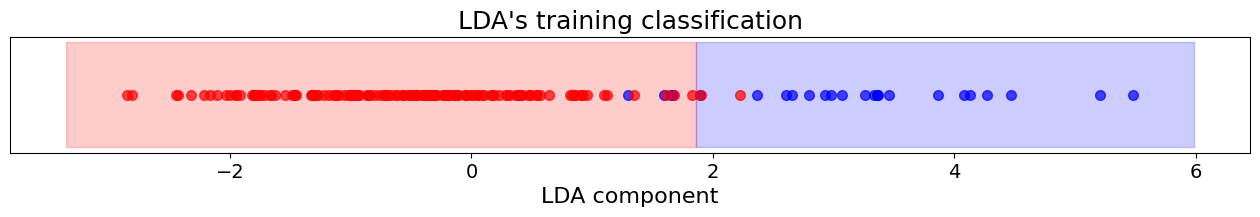

In [ ]:
# Create a plot of the embedding with the target variable as color
positive = X_lda[train_y == 1]
negative = X_lda[train_y == 0]

# Find the midpoint between the rightmost blue point and the leftmost red point
midpoint = -b / w

plt.figure(figsize=(16, 1.5))

plt.plot(
    positive[:, 0],
    np.zeros_like(positive[:, 0]),
    "bo",
    alpha=0.7,
    label="1",
    markersize=7,
)
plt.plot(
    negative[:, 0],
    np.zeros_like(negative[:, 0]),
    "ro",
    alpha=0.7,
    label="0",
    markersize=7,
)


# Shade the areas on either side of the midpoint
if np.mean(positive[:, 0]) < np.mean(negative[:, 0]):
  plt.fill_betweenx(
      [-5, 5], midpoint, np.min(positive[:, 0]) - 0.5, color="blue", alpha=0.2
  )
  plt.fill_betweenx(
      [-5, 5], np.max(negative[:, 0]) + 0.5, midpoint, color="red", alpha=0.2
  )
else:
  plt.fill_betweenx(
      [-5, 5], midpoint, np.min(negative[:, 0]) - 0.5, color="red", alpha=0.2
  )
  plt.fill_betweenx(
      [-5, 5], np.max(positive[:, 0]) + 0.5, midpoint, color="blue", alpha=0.2
  )

# Add a vertical line at the midpoint
# plt.axvline(midpoint, color='k', linestyle='--')

plt.title(f"LDA's training classification", fontsize=18)
plt.xlabel("LDA component", fontsize=16)
#plt.legend()
plt.gca().get_yaxis().set_visible(False)
plt.show()

#### <font color=#FF5F1F><b>Figure R</b></font>

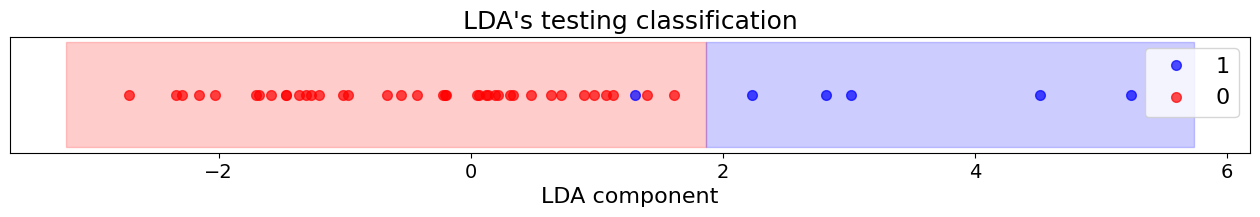

In [ ]:
# Create a plot of the embedding with the target variable as color
positive = X_lda_test[y_test == 1]
negative = X_lda_test[y_test == 0]

# Find the midpoint between the rightmost blue point and the leftmost red point
midpoint = -b / w

plt.figure(figsize=(16, 1.5))

plt.plot(
    positive[:, 0],
    np.zeros_like(positive[:, 0]),
    "bo",
    alpha=0.7,
    label="1",
    markersize=7,
)
plt.plot(
    negative[:, 0],
    np.zeros_like(negative[:, 0]),
    "ro",
    alpha=0.7,
    label="0",
    markersize=7,
)


# Shade the areas on either side of the midpoint
if np.mean(positive[:, 0]) < np.mean(negative[:, 0]):
  plt.fill_betweenx(
      [-5, 5], midpoint, np.min(positive[:, 0]) - 0.5, color="blue", alpha=0.2
  )
  plt.fill_betweenx(
      [-5, 5], np.max(negative[:, 0]) + 0.5, midpoint, color="red", alpha=0.2
  )
else:
  plt.fill_betweenx(
      [-5, 5], midpoint, np.min(negative[:, 0]) - 0.5, color="red", alpha=0.2
  )
  plt.fill_betweenx(
      [-5, 5], np.max(positive[:, 0]) + 0.5, midpoint, color="blue", alpha=0.2
  )

# Add a vertical line at the midpoint

plt.title(f"LDA's testing classification", fontsize=18)
plt.xlabel("LDA component", fontsize=16)
plt.legend(fontsize=16)
plt.gca().get_yaxis().set_visible(False)
plt.show()

In [ ]:
# Calculate evaluation metrics
conf_matrix = confusion_matrix(y_test, y_pred)
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_pred)
cohen_kappa = cohen_kappa_score(y_test, y_pred)

lda_eval = [
    precision,
    recall,
    f1,
    roc_auc,
    cohen_kappa,
]

# Print the evaluation metrics

print("Test set metrics:")
print("Confusion Matrix:\n", conf_matrix)
print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1 score:", f1)
print("ROC AUC score:", roc_auc)
print("Cohen's kappa score:", cohen_kappa)

Test set metrics:
Confusion Matrix:
 [[39  0]
 [ 1  5]]
Accuracy: 0.9777777777777777
Precision: 1.0
Recall: 0.8333333333333334
F1 score: 0.9090909090909091
ROC AUC score: 0.9166666666666667
Cohen's kappa score: 0.896551724137931


## Cross validation

### Proposed method

In [ ]:
# Define the number of folds
k = 5

# Create KFold object
kf = KFold(n_splits=k, shuffle=True, random_state=42)

X_df = dataset_df.drop("class", axis=1)
y_df = dataset_df["class"]

# Reset the index of the DataFrame
X_df = X_df.reset_index(drop=True)
y_df = y_df.reset_index(drop=True)

# Initialize lists to store performance metrics for each fold
accuracy_scores = []
precision_scores = []
recall_scores = []
f1_scores = []
roc_auc_scores = []
kappa_scores = []


# Iterate over the folds
for fold, (train_index, test_index) in enumerate(kf.split(X_df)):
    # Split the data into train and test sets
    train_X, X_test = X_df.iloc[train_index], X_df.iloc[test_index]
    train_y, y_test = y_df.iloc[train_index], y_df.iloc[test_index]

    # Calculating the covariance matrix
    covariance_matrix = train_X.cov()
    C_eigenvalues, C_eigenvectors = np.linalg.eig(covariance_matrix)
    sorted_indices = np.argsort(C_eigenvalues)[::-1]
    C_eigenvalues_sorted = C_eigenvalues[sorted_indices]
    C_eigenvectors_sorted = C_eigenvectors[:, sorted_indices]

    # Resample the training set using RandomOverSampler to address class imbalance
    ros = RandomOverSampler(random_state=42)
    X_train, y_train = ros.fit_resample(train_X, train_y)

    # Set the random seed
    torch.manual_seed(1)

    # Create data loaders for training and test sets
    train_dataset = MyDataset(X_train, y_train)
    test_dataset = MyDataset(X_test, y_test)
    train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=32)

    # Instantiate the model and the optimizer
    model = MyModel(X_train.shape[1])
    optimizer = optim.Adam(model.parameters())

    # Train the model
    num_epochs = 100
    criterion = nn.BCELoss()
    for epoch in range(num_epochs):
        for X_batch, y_batch in train_loader:
            optimizer.zero_grad()
            y_pred = model(X_batch)
            loss = criterion(y_pred, y_batch.unsqueeze(1))
            loss.backward()
            optimizer.step()

    # Set the model to evaluation mode
    model.eval()

    # Compute the average Hessian matrix
    hessian_sum = None
    for i in range(len(train_X)):
        x = torch.tensor(train_X.iloc[i].values, dtype=torch.float32)
        y = torch.tensor([train_y.iloc[i]], dtype=torch.float32)

        hessian_matrix = hessian(lambda inputs: criterion(model(inputs), y), x)

        if hessian_sum is None:
            hessian_sum = hessian_matrix
        else:
            hessian_sum += hessian_matrix

    hessian_matrix_avg = hessian_sum / len(train_X)

    H = hessian_matrix_avg.numpy()
    H_eigenvalues, H_eigenvectors = np.linalg.eig(H)
    H_eigenvectors = np.real(H_eigenvectors)
    sorted_indices = np.argsort(H_eigenvalues)[::-1]
    H_eigenvalues_sorted = H_eigenvalues[sorted_indices]
    H_eigenvectors_sorted = H_eigenvectors[:, sorted_indices]

    # Compute 15-dimensional projections using eigenvectors_sorted
    H_train_proj = np.dot(train_X, H_eigenvectors_sorted[:, :15])

    # Compute 15-dimensional projections using eigenvectors_sorted
    C_train_proj = np.dot(train_X, C_eigenvectors_sorted[:, :15])

    # Compute 15-dimensional projections using eigenvectors_sorted
    H_test_proj = np.dot(X_test, H_eigenvectors_sorted[:, :15])

    # Compute 15-dimensional projections using eigenvectors_sorted
    C_test_proj = np.dot(X_test, C_eigenvectors_sorted[:, :15])

    # Separate features and target variable
    X_train_proj = np.stack((H_train_proj[:, 0], C_train_proj[:, 0]), axis=1)

    X_test_proj = np.stack((H_test_proj[:, 0], C_test_proj[:, 0]), axis=1)

    # Initialize the LinearSVC classifier
    classifier = LinearSVC(random_state=1)

    # Train the classifier on the training set
    classifier.fit(X_train_proj, train_y)

    # Make predictions on the training and test sets
    y_test_pred = classifier.predict(X_test_proj)

    test_acc = accuracy_score(y_test, y_test_pred)
    test_precision = precision_score(y_test, y_test_pred)
    test_recall = recall_score(y_test, y_test_pred)
    test_f1 = f1_score(y_test, y_test_pred)
    test_roc_auc = roc_auc_score(y_test, y_test_pred)
    test_kappa = cohen_kappa_score(y_test, y_test_pred)

    # Print the performance metrics for the current fold
    print(
        f"Fold {fold + 1}: Accuracy={test_acc}, Precision={test_precision}, Recall={test_recall}, F1={test_f1}, ROC AUC={test_roc_auc}, Cohen's Kappa={test_kappa}"
    )

    # Append the performance metrics to the respective lists
    accuracy_scores.append(test_acc)
    precision_scores.append(test_precision)
    recall_scores.append(test_recall)
    f1_scores.append(test_f1)
    roc_auc_scores.append(test_roc_auc)
    kappa_scores.append(test_kappa)

# Calculate and print the average performance across all folds
print("Average Performance:")
proposed_values = [
    np.mean(precision_scores),
    np.mean(recall_scores),
    np.mean(f1_scores),
    np.mean(roc_auc_scores),
    np.mean(kappa_scores),
]
print(
    f"Accuracy={np.mean(accuracy_scores)}, Precision={np.mean(precision_scores)}, Recall={np.mean(recall_scores)}, F1={np.mean(f1_scores)}, ROC AUC={np.mean(roc_auc_scores)}, Cohen's Kappa={np.mean(kappa_scores)}"
)

Fold 1: Accuracy=0.9777777777777777, Precision=0.8571428571428571, Recall=1.0, F1=0.923076923076923, ROC AUC=0.9871794871794871, Cohen's Kappa=0.9101796407185628
Fold 2: Accuracy=0.9318181818181818, Precision=0.8333333333333334, Recall=0.7142857142857143, F1=0.7692307692307692, ROC AUC=0.8436293436293437, Cohen's Kappa=0.7295081967213115
Fold 3: Accuracy=0.9545454545454546, Precision=0.8571428571428571, Recall=0.8571428571428571, F1=0.8571428571428571, ROC AUC=0.9150579150579151, Cohen's Kappa=0.8301158301158301
Fold 4: Accuracy=0.9772727272727273, Precision=1.0, Recall=0.8, F1=0.888888888888889, ROC AUC=0.9, Cohen's Kappa=0.8764044943820225
Fold 5: Accuracy=0.9318181818181818, Precision=0.7142857142857143, Recall=0.8333333333333334, F1=0.7692307692307692, ROC AUC=0.8903508771929826, Cohen's Kappa=0.7295081967213115
Average Performance:
Accuracy=0.9546464646464645, Precision=0.8523809523809524, Recall=0.840952380952381, F1=0.8415140415140414, ROC AUC=0.9072435246119458, Cohen's Kappa=0

### Hessian method

In [ ]:
# Define the number of folds
k = 5

# Create KFold object
kf = KFold(n_splits=k, shuffle=True, random_state=42)

X_df = dataset_df.drop("class", axis=1)
y_df = dataset_df["class"]

# Reset the index of the DataFrame
X_df = X_df.reset_index(drop=True)
y_df = y_df.reset_index(drop=True)

# Initialize lists to store performance metrics for each fold
accuracy_scores = []
precision_scores = []
recall_scores = []
f1_scores = []
roc_auc_scores = []
kappa_scores = []


# Iterate over the folds
for fold, (train_index, test_index) in enumerate(kf.split(X_df)):
    # Split the data into train and test sets
    train_X, X_test = X_df.iloc[train_index], X_df.iloc[test_index]
    train_y, y_test = y_df.iloc[train_index], y_df.iloc[test_index]

    # Resample the training set using RandomOverSampler to address class imbalance
    ros = RandomOverSampler(random_state=42)
    X_train, y_train = ros.fit_resample(train_X, train_y)

    # Set the random seed
    torch.manual_seed(1)

    # Create data loaders for training and test sets
    train_dataset = MyDataset(X_train, y_train)
    train_dataset = MyDataset(train_X, train_y)
    test_dataset = MyDataset(X_test, y_test)
    train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=32)

    # Instantiate the model and the optimizer
    model = MyModel(X_train.shape[1])
    optimizer = optim.Adam(model.parameters())

    # Train the model
    num_epochs = 100
    criterion = nn.BCELoss()
    for epoch in range(num_epochs):
        for X_batch, y_batch in train_loader:
            optimizer.zero_grad()
            y_pred = model(X_batch)
            loss = criterion(y_pred, y_batch.unsqueeze(1))
            loss.backward()
            optimizer.step()

    # Set the model to evaluation mode
    model.eval()

    # Compute the average Hessian matrix
    hessian_sum = None
    for i in range(len(train_X)):
        x = torch.tensor(train_X.iloc[i].values, dtype=torch.float32)
        y = torch.tensor([train_y.iloc[i]], dtype=torch.float32)

        hessian_matrix = hessian(lambda inputs: criterion(model(inputs), y), x)

        if hessian_sum is None:
            hessian_sum = hessian_matrix
        else:
            hessian_sum += hessian_matrix

    hessian_matrix_avg = hessian_sum / len(train_X)

    H = hessian_matrix_avg.numpy()
    H_eigenvalues, H_eigenvectors = np.linalg.eig(H)
    H_eigenvectors = np.real(H_eigenvectors)
    sorted_indices = np.argsort(H_eigenvalues)[::-1]
    H_eigenvalues_sorted = H_eigenvalues[sorted_indices]
    H_eigenvectors_sorted = H_eigenvectors[:, sorted_indices]

    # Compute 15-dimensional projections using eigenvectors_sorted
    H_train_proj = np.dot(train_X, H_eigenvectors_sorted[:, :15])

    # Compute 15-dimensional projections using eigenvectors_sorted
    H_test_proj = np.dot(X_test, H_eigenvectors_sorted[:, :15])

    # Separate features and target variable
    X_train_proj = np.stack((H_train_proj[:, 0], H_train_proj[:, 1]), axis=1)

    X_test_proj = np.stack((H_test_proj[:, 0], H_test_proj[:, 1]), axis=1)

    # Initialize the LinearSVC classifier
    classifier = LinearSVC(random_state=1)

    # Train the classifier on the training set
    classifier.fit(X_train_proj, train_y)

    # Make predictions on the training and test sets
    y_test_pred = classifier.predict(X_test_proj)

    test_acc = accuracy_score(y_test, y_test_pred)
    test_precision = precision_score(y_test, y_test_pred)
    test_recall = recall_score(y_test, y_test_pred)
    test_f1 = f1_score(y_test, y_test_pred)
    test_roc_auc = roc_auc_score(y_test, y_test_pred)
    test_kappa = cohen_kappa_score(y_test, y_test_pred)

    # Print the performance metrics for the current fold
    print(
        f"Fold {fold + 1}: Accuracy={test_acc}, Precision={test_precision}, Recall={test_recall}, F1={test_f1}, ROC AUC={test_roc_auc}, Cohen's Kappa={test_kappa}"
    )

    # Append the performance metrics to the respective lists
    accuracy_scores.append(test_acc)
    precision_scores.append(test_precision)
    recall_scores.append(test_recall)
    f1_scores.append(test_f1)
    roc_auc_scores.append(test_roc_auc)
    kappa_scores.append(test_kappa)

# Calculate and print the average performance across all folds
print("Average Performance:")
hessian_values = [
    np.mean(precision_scores),
    np.mean(recall_scores),
    np.mean(f1_scores),
    np.mean(roc_auc_scores),
    np.mean(kappa_scores),
]
print(
    f"Accuracy={np.mean(accuracy_scores)}, Precision={np.mean(precision_scores)}, Recall={np.mean(recall_scores)}, F1={np.mean(f1_scores)}, ROC AUC={np.mean(roc_auc_scores)}, Cohen's Kappa={np.mean(kappa_scores)}"
)

Fold 1: Accuracy=0.9777777777777777, Precision=1.0, Recall=0.8333333333333334, F1=0.9090909090909091, ROC AUC=0.9166666666666667, Cohen's Kappa=0.896551724137931
Fold 2: Accuracy=0.9545454545454546, Precision=0.8571428571428571, Recall=0.8571428571428571, F1=0.8571428571428571, ROC AUC=0.9150579150579151, Cohen's Kappa=0.8301158301158301
Fold 3: Accuracy=0.9318181818181818, Precision=0.8333333333333334, Recall=0.7142857142857143, F1=0.7692307692307692, ROC AUC=0.8436293436293437, Cohen's Kappa=0.7295081967213115
Fold 4: Accuracy=0.9772727272727273, Precision=1.0, Recall=0.8, F1=0.888888888888889, ROC AUC=0.9, Cohen's Kappa=0.8764044943820225
Fold 5: Accuracy=0.9090909090909091, Precision=0.6666666666666666, Recall=0.6666666666666666, F1=0.6666666666666666, ROC AUC=0.8070175438596492, Cohen's Kappa=0.6140350877192982
Average Performance:
Accuracy=0.9501010101010101, Precision=0.8714285714285716, Recall=0.7742857142857142, F1=0.8182040182040181, ROC AUC=0.8764742938427149, Cohen's Kappa=

### PCA

In [ ]:
# Define the number of folds
k = 5

# Create KFold object
kf = KFold(n_splits=k, shuffle=True, random_state=42)

X_df = dataset_df.drop("class", axis=1)
y_df = dataset_df["class"]

# Reset the index of the DataFrame
X_df = X_df.reset_index(drop=True)
y_df = y_df.reset_index(drop=True)

# Initialize lists to store performance metrics for each fold
accuracy_scores = []
precision_scores = []
recall_scores = []
f1_scores = []
roc_auc_scores = []
kappa_scores = []


# Iterate over the folds
for fold, (train_index, test_index) in enumerate(kf.split(X_df)):
    # Split the data into train and test sets
    train_X, X_test = X_df.iloc[train_index], X_df.iloc[test_index]
    train_y, y_test = y_df.iloc[train_index], y_df.iloc[test_index]

    # Calculating the covariance matrix
    covariance_matrix = train_X.cov()
    C_eigenvalues, C_eigenvectors = np.linalg.eig(covariance_matrix)
    sorted_indices = np.argsort(C_eigenvalues)[::-1]
    C_eigenvalues_sorted = C_eigenvalues[sorted_indices]
    C_eigenvectors_sorted = C_eigenvectors[:, sorted_indices]

    # Compute 15-dimensional projections using eigenvectors_sorted
    C_train_proj = np.dot(train_X, C_eigenvectors_sorted[:, :15])

    # Compute 15-dimensional projections using eigenvectors_sorted
    C_test_proj = np.dot(X_test, C_eigenvectors_sorted[:, :15])

    # Separate features and target variable
    X_train_proj = np.stack((C_train_proj[:, 0], C_train_proj[:, 1]), axis=1)

    X_test_proj = np.stack((C_test_proj[:, 0], C_test_proj[:, 1]), axis=1)

    # Initialize the LinearSVC classifier
    classifier = LinearSVC(random_state=1)

    # Train the classifier on the training set
    classifier.fit(X_train_proj, train_y)

    # Make predictions on the training and test sets
    y_test_pred = classifier.predict(X_test_proj)

    test_acc = accuracy_score(y_test, y_test_pred)
    test_precision = precision_score(y_test, y_test_pred)
    test_recall = recall_score(y_test, y_test_pred)
    test_f1 = f1_score(y_test, y_test_pred)
    test_roc_auc = roc_auc_score(y_test, y_test_pred)
    test_kappa = cohen_kappa_score(y_test, y_test_pred)

    # Print the performance metrics for the current fold
    print(
        f"Fold {fold + 1}: Accuracy={test_acc}, Precision={test_precision}, Recall={test_recall}, F1={test_f1}, ROC AUC={test_roc_auc}, Cohen's Kappa={test_kappa}"
    )

    # Append the performance metrics to the respective lists
    accuracy_scores.append(test_acc)
    precision_scores.append(test_precision)
    recall_scores.append(test_recall)
    f1_scores.append(test_f1)
    roc_auc_scores.append(test_roc_auc)
    kappa_scores.append(test_kappa)

# Calculate and print the average performance across all folds
print("Average Performance:")
cov_values = [
    np.mean(precision_scores),
    np.mean(recall_scores),
    np.mean(f1_scores),
    np.mean(roc_auc_scores),
    np.mean(kappa_scores),
]
print(
    f"Accuracy={np.mean(accuracy_scores)}, Precision={np.mean(precision_scores)}, Recall={np.mean(recall_scores)}, F1={np.mean(f1_scores)}, ROC AUC={np.mean(roc_auc_scores)}, Cohen's Kappa={np.mean(kappa_scores)}"
)

Fold 1: Accuracy=0.9555555555555556, Precision=1.0, Recall=0.6666666666666666, F1=0.8, ROC AUC=0.8333333333333333, Cohen's Kappa=0.7761194029850746
Fold 2: Accuracy=0.8863636363636364, Precision=1.0, Recall=0.2857142857142857, F1=0.4444444444444445, ROC AUC=0.6428571428571428, Cohen's Kappa=0.40217391304347827
Fold 3: Accuracy=0.8863636363636364, Precision=0.75, Recall=0.42857142857142855, F1=0.5454545454545454, ROC AUC=0.7007722007722008, Cohen's Kappa=0.4859813084112149
Fold 4: Accuracy=0.9545454545454546, Precision=1.0, Recall=0.6, F1=0.7499999999999999, ROC AUC=0.8, Cohen's Kappa=0.7267080745341614
Fold 5: Accuracy=0.7954545454545454, Precision=0.2, Recall=0.16666666666666666, F1=0.1818181818181818, ROC AUC=0.530701754385965, Cohen's Kappa=0.06603773584905659
Average Performance:
Accuracy=0.8956565656565656, Precision=0.79, Recall=0.42952380952380953, F1=0.5443434343434344, ROC AUC=0.7015328862697283, Cohen's Kappa=0.49140408696459714


### UMAP

In [ ]:
# Define the number of folds
k = 5

# Create KFold object
kf = KFold(n_splits=k, shuffle=True, random_state=42)

X_df = dataset_df.drop("class", axis=1)
y_df = dataset_df["class"]

# Reset the index of the DataFrame
X_df = X_df.reset_index(drop=True)
y_df = y_df.reset_index(drop=True)

# Initialize lists to store performance metrics for each fold
accuracy_scores = []
precision_scores = []
recall_scores = []
f1_scores = []
roc_auc_scores = []
kappa_scores = []


# Iterate over the folds
for fold, (train_index, test_index) in enumerate(kf.split(X_df)):
    # Split the data into train and test sets
    train_X, X_test = X_df.iloc[train_index], X_df.iloc[test_index]
    train_y, y_test = y_df.iloc[train_index], y_df.iloc[test_index]

    # Define the target variable and the features
    target = train_y
    features = train_X

    # Create a supervised UMAP object
    umap_supervised = umap.UMAP(
        n_neighbors=20, n_components=2, metric="euclidean", random_state=23
    )

    # Fit the UMAP model with the features and target variable
    embedding = umap_supervised.fit_transform(features, y=target)

    # Separate features and target variable
    X_train_umap = pd.DataFrame(embedding)
    y_train_umap = target

    X_test_umap = umap_supervised.transform(X_test)

    # Initialize the LinearSVC classifier
    classifier = LinearSVC(random_state=1)

    # Train the classifier on the training set
    classifier.fit(X_train_umap, target)

    # Make predictions on the training and test sets
    y_test_pred = classifier.predict(X_test_umap)

    test_acc = accuracy_score(y_test, y_test_pred)
    test_precision = precision_score(y_test, y_test_pred)
    test_recall = recall_score(y_test, y_test_pred)
    test_f1 = f1_score(y_test, y_test_pred)
    test_roc_auc = roc_auc_score(y_test, y_test_pred)
    test_kappa = cohen_kappa_score(y_test, y_test_pred)

    # Print the performance metrics for the current fold
    print(
        f"Fold {fold + 1}: Accuracy={test_acc}, Precision={test_precision}, Recall={test_recall}, F1={test_f1}, ROC AUC={test_roc_auc}, Cohen's Kappa={test_kappa}"
    )

    # Append the performance metrics to the respective lists
    accuracy_scores.append(test_acc)
    precision_scores.append(test_precision)
    recall_scores.append(test_recall)
    f1_scores.append(test_f1)
    roc_auc_scores.append(test_roc_auc)
    kappa_scores.append(test_kappa)

# Calculate and print the average performance across all folds
print("Average Performance:")
umap_values = [
    np.mean(precision_scores),
    np.mean(recall_scores),
    np.mean(f1_scores),
    np.mean(roc_auc_scores),
    np.mean(kappa_scores),
]
print(
    f"Accuracy={np.mean(accuracy_scores)}, Precision={np.mean(precision_scores)}, Recall={np.mean(recall_scores)}, F1={np.mean(f1_scores)}, ROC AUC={np.mean(roc_auc_scores)}, Cohen's Kappa={np.mean(kappa_scores)}"
)

Fold 1: Accuracy=0.8888888888888888, Precision=1.0, Recall=0.16666666666666666, F1=0.2857142857142857, ROC AUC=0.5833333333333334, Cohen's Kappa=0.2574257425742573
Fold 2: Accuracy=0.8409090909090909, Precision=0.0, Recall=0.0, F1=0.0, ROC AUC=0.5, Cohen's Kappa=0.0
Fold 3: Accuracy=0.8636363636363636, Precision=1.0, Recall=0.14285714285714285, F1=0.25, ROC AUC=0.5714285714285714, Cohen's Kappa=0.21893491124260356
Fold 4: Accuracy=0.8863636363636364, Precision=0.0, Recall=0.0, F1=0.0, ROC AUC=0.5, Cohen's Kappa=0.0
Fold 5: Accuracy=0.8636363636363636, Precision=0.0, Recall=0.0, F1=0.0, ROC AUC=0.5, Cohen's Kappa=0.0
Average Performance:
Accuracy=0.8686868686868687, Precision=0.4, Recall=0.06190476190476191, F1=0.10714285714285714, ROC AUC=0.5309523809523811, Cohen's Kappa=0.09527213076337218


### LDA

In [ ]:
# Define the number of folds
k = 5

# Create KFold object
kf = KFold(n_splits=k, shuffle=True, random_state=42)

X_df = dataset_df.drop("class", axis=1)
y_df = dataset_df["class"]

# Reset the index of the DataFrame
X_df = X_df.reset_index(drop=True)
y_df = y_df.reset_index(drop=True)

# Initialize lists to store performance metrics for each fold
accuracy_scores = []
precision_scores = []
recall_scores = []
f1_scores = []
roc_auc_scores = []
kappa_scores = []

# Iterate over the folds
for fold, (train_index, test_index) in enumerate(kf.split(X_df)):
    # Split the data into train and test sets
    train_X, X_test = X_df.iloc[train_index], X_df.iloc[test_index]
    train_y, y_test = y_df.iloc[train_index], y_df.iloc[test_index]

    # Creating an instance of the LDA class
    lda = LinearDiscriminantAnalysis()

    # Fitting the LDA model to the data
    lda.fit(train_X, train_y)

    # Transforming the data to the LDA space
    X_lda = lda.transform(train_X)

    # Fit the SVM model to the training data
    svm = SVC(kernel="linear")
    svm.fit(X_lda, train_y)

    # Make predictions on the test data
    X_lda_test = lda.transform(X_test)
    y_test_pred = svm.predict(X_lda_test)

    test_acc = accuracy_score(y_test, y_test_pred)
    test_precision = precision_score(y_test, y_test_pred)
    test_recall = recall_score(y_test, y_test_pred)
    test_f1 = f1_score(y_test, y_test_pred)
    test_roc_auc = roc_auc_score(y_test, y_test_pred)
    test_kappa = cohen_kappa_score(y_test, y_test_pred)

    # Print the performance metrics for the current fold
    print(
        f"Fold {fold + 1}: Accuracy={test_acc}, Precision={test_precision}, Recall={test_recall}, F1={test_f1}, ROC AUC={test_roc_auc}, Cohen's Kappa={test_kappa}"
    )

    # Append the performance metrics to the respective lists
    accuracy_scores.append(test_acc)
    precision_scores.append(test_precision)
    recall_scores.append(test_recall)
    f1_scores.append(test_f1)
    roc_auc_scores.append(test_roc_auc)
    kappa_scores.append(test_kappa)

# Calculate and print the average performance across all folds
print("Average Performance:")
lda_values = [np.mean(precision_scores), np.mean(recall_scores), np.mean(f1_scores), np.mean(roc_auc_scores), np.mean(kappa_scores)]
print(
    f"Accuracy={np.mean(accuracy_scores)}, Precision={np.mean(precision_scores)}, Recall={np.mean(recall_scores)}, F1={np.mean(f1_scores)}, ROC AUC={np.mean(roc_auc_scores)}, Cohen's Kappa={np.mean(kappa_scores)}"
)


Fold 1: Accuracy=0.9777777777777777, Precision=1.0, Recall=0.8333333333333334, F1=0.9090909090909091, ROC AUC=0.9166666666666667, Cohen's Kappa=0.896551724137931
Fold 2: Accuracy=0.9545454545454546, Precision=0.8571428571428571, Recall=0.8571428571428571, F1=0.8571428571428571, ROC AUC=0.9150579150579151, Cohen's Kappa=0.8301158301158301
Fold 3: Accuracy=0.9772727272727273, Precision=1.0, Recall=0.8571428571428571, F1=0.923076923076923, ROC AUC=0.9285714285714286, Cohen's Kappa=0.9098360655737705
Fold 4: Accuracy=0.9545454545454546, Precision=0.8, Recall=0.8, F1=0.8000000000000002, ROC AUC=0.8871794871794871, Cohen's Kappa=0.7743589743589744
Fold 5: Accuracy=0.8863636363636364, Precision=0.6, Recall=0.5, F1=0.5454545454545454, ROC AUC=0.7236842105263158, Cohen's Kappa=0.4811320754716981
Average Performance:
Accuracy=0.9501010101010101, Precision=0.8514285714285714, Recall=0.7695238095238095, F1=0.806953046953047, ROC AUC=0.8742319416003627, Cohen's Kappa=0.7783989339316408


### Kernel PCA with linear kernel

In [ ]:
X_df = dataset_df.drop("class", axis=1)
y_df = dataset_df["class"]

# Reset the index of the DataFrame
X_df = X_df.reset_index(drop=True)
y_df = y_df.reset_index(drop=True)

# Define the number of folds
k = 5

# Create KFold object
kf = KFold(n_splits=k, shuffle=True, random_state=42)

# Initialize lists to store performance metrics for each fold
accuracy_scores = []
precision_scores = []
recall_scores = []
f1_scores = []
roc_auc_scores = []
kappa_scores = []

# Iterate over the folds
for fold, (train_index, test_index) in enumerate(kf.split(X_df)):
    # Split the data into train and test sets
    train_X, X_test = X_df.iloc[train_index], X_df.iloc[test_index]
    train_y, y_test = y_df.iloc[train_index], y_df.iloc[test_index]

    # Define the target variable and the features
    target = train_y
    features = train_X

    # Create a kernel PCA object with the best parameters
    kpca = KernelPCA(kernel='linear', n_components=2)

    # Fit the kernel PCA model with the features
    X_train_kpca = kpca.fit_transform(features)

    # Separate features and target variable
    y_train_kpca = target

    # Transform the test set using the kernel PCA model
    X_test_kpca = kpca.transform(X_test)

    # Initialize the LinearSVC classifier
    classifier = LinearSVC(random_state=1)

    # Train the classifier on the training set
    classifier.fit(X_train_kpca, target)

    # Make predictions on the training and test sets
    y_test_pred = classifier.predict(X_test_kpca)

    # Calculate performance metrics for the current fold
    test_acc = accuracy_score(y_test, y_test_pred)
    test_precision = precision_score(y_test, y_test_pred)
    test_recall = recall_score(y_test, y_test_pred)
    test_f1 = f1_score(y_test, y_test_pred)
    test_roc_auc = roc_auc_score(y_test, y_test_pred)
    test_kappa = cohen_kappa_score(y_test, y_test_pred)

    # Print the performance metrics for the current fold
    print(
        f"Fold {fold + 1}: Accuracy={test_acc}, Precision={test_precision}, Recall={test_recall}, F1={test_f1}, ROC AUC={test_roc_auc}, Cohen's Kappa={test_kappa}"
    )

    # Append the performance metrics to the respective lists
    accuracy_scores.append(test_acc)
    precision_scores.append(test_precision)
    recall_scores.append(test_recall)
    f1_scores.append(test_f1)
    roc_auc_scores.append(test_roc_auc)
    kappa_scores.append(test_kappa)

# Calculate and print the average performance across all folds
print("Average Performance:")
pca_values = [
    np.mean(precision_scores),
    np.mean(recall_scores),
    np.mean(f1_scores),
    np.mean(roc_auc_scores),
    np.mean(kappa_scores),
]
print(
    f"Accuracy={np.mean(accuracy_scores)}, Precision={np.mean(precision_scores)}, Recall={np.mean(recall_scores)}, F1={np.mean(f1_scores)}, ROC AUC={np.mean(roc_auc_scores)}, Cohen's Kappa={np.mean(kappa_scores)}"
)

Fold 1: Accuracy=0.9555555555555556, Precision=1.0, Recall=0.6666666666666666, F1=0.8, ROC AUC=0.8333333333333333, Cohen's Kappa=0.7761194029850746
Fold 2: Accuracy=0.8863636363636364, Precision=1.0, Recall=0.2857142857142857, F1=0.4444444444444445, ROC AUC=0.6428571428571428, Cohen's Kappa=0.40217391304347827
Fold 3: Accuracy=0.8863636363636364, Precision=0.75, Recall=0.42857142857142855, F1=0.5454545454545454, ROC AUC=0.7007722007722008, Cohen's Kappa=0.4859813084112149
Fold 4: Accuracy=0.9545454545454546, Precision=1.0, Recall=0.6, F1=0.7499999999999999, ROC AUC=0.8, Cohen's Kappa=0.7267080745341614
Fold 5: Accuracy=0.7954545454545454, Precision=0.2, Recall=0.16666666666666666, F1=0.1818181818181818, ROC AUC=0.530701754385965, Cohen's Kappa=0.06603773584905659
Average Performance:
Accuracy=0.8956565656565656, Precision=0.79, Recall=0.42952380952380953, F1=0.5443434343434344, ROC AUC=0.7015328862697283, Cohen's Kappa=0.49140408696459714


### Kernel PCA

In [ ]:
# Define the dataset_df, assuming it's already loaded

X_df = dataset_df.drop("class", axis=1)
y_df = dataset_df["class"]

# Reset the index of the DataFrame
X_df = X_df.reset_index(drop=True)
y_df = y_df.reset_index(drop=True)

# Define the parameter grid for KDA
param_grid = {
    'kernel': ['linear', 'poly', 'rbf', 'sigmoid', 'cosine'],
    'gamma': [0.01, 0.1, 1, 10],
    'degree': [2, 3, 4]
}



# Use KFold for cross-validation
k = 5
kf = KFold(n_splits=k, shuffle=True, random_state=42)

# Initialize variables to store the best parameters and corresponding score
best_params = None
best_score = 0.0  # Assuming higher F1 score is better

print("Best parameter search:\n")

# Iterate through parameter combinations
for kernel in param_grid['kernel']:
    for gamma in param_grid['gamma']:
        for degree in param_grid['degree']:
            # Initialize KDA with current parameters
            kpca = KernelPCA(n_components=2, kernel=kernel, gamma=gamma, degree=degree)

            # Perform cross-validation
            scores = []

            for train_index, test_index in kf.split(X_df):
                X_train, X_test = X_df.iloc[train_index], X_df.iloc[test_index]
                y_train, y_test = y_df.iloc[train_index], y_df.iloc[test_index]

                # Define the target variable and the features
                target = y_train
                features = X_train


                try:
                    # Fit the kernel PCA model with the features
                    X_train_kpca = kpca.fit_transform(features)

                    # Transform the test set using the kernel PCA model
                    X_test_kpca = kpca.transform(X_test)

                except Exception as e:
                    # Handle the case where eigenanalysis fails
                    print(f"Eigenanalysis failed for some fold: {e}. Skipping this fold.\n")
                    continue


                # Initialize the LinearSVC classifier
                classifier = LinearSVC(random_state=1)

                # Train the classifier on the training set
                classifier.fit(X_train_kpca, target)

                # Make predictions on the training and test sets
                y_test_pred = classifier.predict(X_test_kpca)

                # Calculate F1 score and store
                score = f1_score(y_test, y_test_pred)
                scores.append(score)

            # Calculate average F1 score across folds
            avg_score = np.mean(scores)

            # Update best parameters if current combination is better
            if avg_score > best_score:
                best_score = avg_score
                best_params = {'kernel': kernel, 'gamma': gamma, 'degree': degree}
                print(f"Best parameters: {best_params}")
                print(f"Best F1 score: {best_score} \n")

# Print the best parameters and corresponding score
print(f"Final best parameters: {best_params}")
print(f"Final best F1 score: {best_score}")

Best parameter search:

Best parameters: {'kernel': 'linear', 'gamma': 0.01, 'degree': 2}
Best F1 score: 0.5443434343434344 

Eigenanalysis failed for some fold: zero-size array to reduction operation maximum which has no identity. Skipping this fold.

Eigenanalysis failed for some fold: zero-size array to reduction operation maximum which has no identity. Skipping this fold.

Eigenanalysis failed for some fold: zero-size array to reduction operation maximum which has no identity. Skipping this fold.

Final best parameters: {'kernel': 'linear', 'gamma': 0.01, 'degree': 2}
Final best F1 score: 0.5443434343434344


In [ ]:
X_df = dataset_df.drop("class", axis=1)
y_df = dataset_df["class"]

# Reset the index of the DataFrame
X_df = X_df.reset_index(drop=True)
y_df = y_df.reset_index(drop=True)

# Define the number of folds
k = 5

# Create KFold object
kf = KFold(n_splits=k, shuffle=True, random_state=42)

# Initialize lists to store performance metrics for each fold
accuracy_scores = []
precision_scores = []
recall_scores = []
f1_scores = []
roc_auc_scores = []
kappa_scores = []

# Iterate over the folds
for fold, (train_index, test_index) in enumerate(kf.split(X_df)):
    # Split the data into train and test sets
    train_X, X_test = X_df.iloc[train_index], X_df.iloc[test_index]
    train_y, y_test = y_df.iloc[train_index], y_df.iloc[test_index]

    # Define the target variable and the features
    target = train_y
    features = train_X

    # Create a kernel PCA object with the best parameters
    kpca = KernelPCA(n_components=2, **best_params)

    # Fit the kernel PCA model with the features
    X_train_kpca = kpca.fit_transform(features)

    # Separate features and target variable
    y_train_kpca = target

    # Transform the test set using the kernel PCA model
    X_test_kpca = kpca.transform(X_test)

    # Initialize the LinearSVC classifier
    classifier = LinearSVC(random_state=1)

    # Train the classifier on the training set
    classifier.fit(X_train_kpca, target)

    # Make predictions on the training and test sets
    y_test_pred = classifier.predict(X_test_kpca)

    # Calculate performance metrics for the current fold
    test_acc = accuracy_score(y_test, y_test_pred)
    test_precision = precision_score(y_test, y_test_pred)
    test_recall = recall_score(y_test, y_test_pred)
    test_f1 = f1_score(y_test, y_test_pred)
    test_roc_auc = roc_auc_score(y_test, y_test_pred)
    test_kappa = cohen_kappa_score(y_test, y_test_pred)

    # Print the performance metrics for the current fold
    print(
        f"Fold {fold + 1}: Accuracy={test_acc}, Precision={test_precision}, Recall={test_recall}, F1={test_f1}, ROC AUC={test_roc_auc}, Cohen's Kappa={test_kappa}"
    )

    # Append the performance metrics to the respective lists
    accuracy_scores.append(test_acc)
    precision_scores.append(test_precision)
    recall_scores.append(test_recall)
    f1_scores.append(test_f1)
    roc_auc_scores.append(test_roc_auc)
    kappa_scores.append(test_kappa)

# Calculate and print the average performance across all folds
print("Average Performance:")
kpca_values = [
    np.mean(precision_scores),
    np.mean(recall_scores),
    np.mean(f1_scores),
    np.mean(roc_auc_scores),
    np.mean(kappa_scores),
]
print(
    f"Accuracy={np.mean(accuracy_scores)}, Precision={np.mean(precision_scores)}, Recall={np.mean(recall_scores)}, F1={np.mean(f1_scores)}, ROC AUC={np.mean(roc_auc_scores)}, Cohen's Kappa={np.mean(kappa_scores)}"
)

Fold 1: Accuracy=0.9555555555555556, Precision=1.0, Recall=0.6666666666666666, F1=0.8, ROC AUC=0.8333333333333333, Cohen's Kappa=0.7761194029850746
Fold 2: Accuracy=0.8863636363636364, Precision=1.0, Recall=0.2857142857142857, F1=0.4444444444444445, ROC AUC=0.6428571428571428, Cohen's Kappa=0.40217391304347827
Fold 3: Accuracy=0.8863636363636364, Precision=0.75, Recall=0.42857142857142855, F1=0.5454545454545454, ROC AUC=0.7007722007722008, Cohen's Kappa=0.4859813084112149
Fold 4: Accuracy=0.9545454545454546, Precision=1.0, Recall=0.6, F1=0.7499999999999999, ROC AUC=0.8, Cohen's Kappa=0.7267080745341614
Fold 5: Accuracy=0.7954545454545454, Precision=0.2, Recall=0.16666666666666666, F1=0.1818181818181818, ROC AUC=0.530701754385965, Cohen's Kappa=0.06603773584905659
Average Performance:
Accuracy=0.8956565656565656, Precision=0.79, Recall=0.42952380952380953, F1=0.5443434343434344, ROC AUC=0.7015328862697283, Cohen's Kappa=0.49140408696459714


### Kernel DA with linear kernel

In [ ]:
# Define the dataset_df, assuming it's already loaded

X_df = dataset_df.drop("class", axis=1)
y_df = dataset_df["class"]

# Reset the index of the DataFrame
X_df = X_df.reset_index(drop=True)
y_df = y_df.reset_index(drop=True)


# Define the number of folds
k = 5

# Create KFold object
kf = KFold(n_splits=k, shuffle=True, random_state=42)

# Initialize lists to store performance metrics for each fold
accuracy_scores = []
precision_scores = []
recall_scores = []
f1_scores = []
roc_auc_scores = []
kappa_scores = []

# Iterate over the folds
for fold, (train_index, test_index) in enumerate(kf.split(X_df)):
    # Split the data into train and test sets
    train_X, X_test = X_df.iloc[train_index], X_df.iloc[test_index]
    train_y, y_test = y_df.iloc[train_index], y_df.iloc[test_index]

    # Define the target variable and the features
    target = train_y
    features = train_X

    # Create a kernel PCA object with the best parameters
    klda = KDA(n_components=2, kernel='linear')

    # Fit the kernel PCA model with the features
    X_train_klda = klda.fit_transform(features, target)

    # Transform the test set using the kernel PCA model
    X_test_klda = klda.transform(X_test)

    # Initialize the LinearSVC classifier
    classifier = LinearSVC(random_state=1)

    # Train the classifier on the training set
    classifier.fit(X_train_klda, target)

    # Make predictions on the training and test sets
    y_test_pred = classifier.predict(X_test_klda)

    # Calculate performance metrics for the current fold
    test_acc = accuracy_score(y_test, y_test_pred)
    test_precision = precision_score(y_test, y_test_pred)
    test_recall = recall_score(y_test, y_test_pred)
    test_f1 = f1_score(y_test, y_test_pred)
    test_roc_auc = roc_auc_score(y_test, y_test_pred)
    test_kappa = cohen_kappa_score(y_test, y_test_pred)

    # Print the performance metrics for the current fold
    print(
        f"Fold {fold + 1}: Accuracy={test_acc}, Precision={test_precision}, Recall={test_recall}, F1={test_f1}, ROC AUC={test_roc_auc}, Cohen's Kappa={test_kappa}"
    )

    # Append the performance metrics to the respective lists
    accuracy_scores.append(test_acc)
    precision_scores.append(test_precision)
    recall_scores.append(test_recall)
    f1_scores.append(test_f1)
    roc_auc_scores.append(test_roc_auc)
    kappa_scores.append(test_kappa)

# Calculate and print the average performance across all folds
print("Average Performance:")
llda_values = [
    np.mean(precision_scores),
    np.mean(recall_scores),
    np.mean(f1_scores),
    np.mean(roc_auc_scores),
    np.mean(kappa_scores),
]
print(
    f"Accuracy={np.mean(accuracy_scores)}, Precision={np.mean(precision_scores)}, Recall={np.mean(recall_scores)}, F1={np.mean(f1_scores)}, ROC AUC={np.mean(roc_auc_scores)}, Cohen's Kappa={np.mean(kappa_scores)}"
)

Fold 1: Accuracy=0.9111111111111111, Precision=1.0, Recall=0.3333333333333333, F1=0.5, ROC AUC=0.6666666666666666, Cohen's Kappa=0.4642857142857143
Fold 2: Accuracy=0.8863636363636364, Precision=1.0, Recall=0.2857142857142857, F1=0.4444444444444445, ROC AUC=0.6428571428571428, Cohen's Kappa=0.40217391304347827
Fold 3: Accuracy=0.8409090909090909, Precision=0.0, Recall=0.0, F1=0.0, ROC AUC=0.5, Cohen's Kappa=0.0
Fold 4: Accuracy=0.9090909090909091, Precision=1.0, Recall=0.2, F1=0.33333333333333337, ROC AUC=0.6, Cohen's Kappa=0.30708661417322847
Fold 5: Accuracy=0.8636363636363636, Precision=0.0, Recall=0.0, F1=0.0, ROC AUC=0.5, Cohen's Kappa=0.0
Average Performance:
Accuracy=0.8822222222222222, Precision=0.6, Recall=0.1638095238095238, F1=0.25555555555555554, ROC AUC=0.5819047619047619, Cohen's Kappa=0.23470924830048423


### Kernel DA

In [ ]:
# Define the dataset_df, assuming it's already loaded

X_df = dataset_df.drop("class", axis=1)
y_df = dataset_df["class"]

# Reset the index of the DataFrame
X_df = X_df.reset_index(drop=True)
y_df = y_df.reset_index(drop=True)

# Define the parameter grid for KDA
param_grid = {
    'kernel': ['linear', 'poly', 'rbf', 'sigmoid', 'cosine'],
    'gamma': [0.01, 0.1, 1, 10],
    'degree': [2, 3, 4]
}



# Use KFold for cross-validation
k = 5
kf = KFold(n_splits=k, shuffle=True, random_state=42)

# Initialize variables to store the best parameters and corresponding score
best_params = None
best_score = 0.0  # Assuming higher F1 score is better

print("Best parameter search:\n")

# Iterate through parameter combinations
for kernel in param_grid['kernel']:
    for gamma in param_grid['gamma']:
        for degree in param_grid['degree']:
            # Initialize KDA with current parameters
            klda = KDA(n_components=1, kernel=kernel, gamma=gamma, degree=degree)

            # Perform cross-validation
            scores = []

            for train_index, test_index in kf.split(X_df):
                X_train, X_test = X_df.iloc[train_index], X_df.iloc[test_index]
                y_train, y_test = y_df.iloc[train_index], y_df.iloc[test_index]

                # Define the target variable and the features
                target = y_train
                features = X_train

                # Fit the kernel PCA model with the features
                X_train_klda = klda.fit_transform(features, target)

                # Transform the test set using the kernel PCA model
                X_test_klda = klda.transform(X_test)

                # Initialize the LinearSVC classifier
                classifier = LinearSVC(random_state=1)

                # Train the classifier on the training set
                classifier.fit(X_train_klda, target)

                # Make predictions on the training and test sets
                y_test_pred = classifier.predict(X_test_klda)

                # Calculate F1 score and store
                score = f1_score(y_test, y_test_pred)
                scores.append(score)

            # Calculate average F1 score across folds
            avg_score = np.mean(scores)

            # Update best parameters if current combination is better
            if avg_score > best_score:
                best_score = avg_score
                best_params = {'kernel': kernel, 'gamma': gamma, 'degree': degree}
                print(f"Best parameters: {best_params}")
                print(f"Best F1 score: {best_score} \n")

# Print the best parameters and corresponding score
print(f"Final best parameters: {best_params}")
print(f"Final best F1 score: {best_score}")


Best parameter search:

Best parameters: {'kernel': 'linear', 'gamma': 0.01, 'degree': 2}
Best F1 score: 0.25555555555555554 

Best parameters: {'kernel': 'poly', 'gamma': 0.01, 'degree': 2}
Best F1 score: 0.5900000000000001 

Best parameters: {'kernel': 'poly', 'gamma': 0.01, 'degree': 3}
Best F1 score: 0.5960606060606061 

Best parameters: {'kernel': 'sigmoid', 'gamma': 1, 'degree': 2}
Best F1 score: 0.6181818181818182 

Final best parameters: {'kernel': 'sigmoid', 'gamma': 1, 'degree': 2}
Final best F1 score: 0.6181818181818182


In [ ]:
# Define the dataset_df, assuming it's already loaded

X_df = dataset_df.drop("class", axis=1)
y_df = dataset_df["class"]

# Reset the index of the DataFrame
X_df = X_df.reset_index(drop=True)
y_df = y_df.reset_index(drop=True)


# Define the number of folds
k = 5

# Create KFold object
kf = KFold(n_splits=k, shuffle=True, random_state=42)

# Initialize lists to store performance metrics for each fold
accuracy_scores = []
precision_scores = []
recall_scores = []
f1_scores = []
roc_auc_scores = []
kappa_scores = []

# Iterate over the folds
for fold, (train_index, test_index) in enumerate(kf.split(X_df)):
    # Split the data into train and test sets
    train_X, X_test = X_df.iloc[train_index], X_df.iloc[test_index]
    train_y, y_test = y_df.iloc[train_index], y_df.iloc[test_index]

    # Define the target variable and the features
    target = train_y
    features = train_X

    # Create a kernel PCA object with the best parameters
    klda = KDA(n_components=1, **best_params)

    # Fit the kernel PCA model with the features
    X_train_klda = klda.fit_transform(features, target)

    # Transform the test set using the kernel PCA model
    X_test_klda = klda.transform(X_test)

    # Initialize the LinearSVC classifier
    classifier = LinearSVC(random_state=1)

    # Train the classifier on the training set
    classifier.fit(X_train_klda, target)

    # Make predictions on the training and test sets
    y_test_pred = classifier.predict(X_test_klda)

    # Calculate performance metrics for the current fold
    test_acc = accuracy_score(y_test, y_test_pred)
    test_precision = precision_score(y_test, y_test_pred)
    test_recall = recall_score(y_test, y_test_pred)
    test_f1 = f1_score(y_test, y_test_pred)
    test_roc_auc = roc_auc_score(y_test, y_test_pred)
    test_kappa = cohen_kappa_score(y_test, y_test_pred)

    # Print the performance metrics for the current fold
    print(
        f"Fold {fold + 1}: Accuracy={test_acc}, Precision={test_precision}, Recall={test_recall}, F1={test_f1}, ROC AUC={test_roc_auc}, Cohen's Kappa={test_kappa}"
    )

    # Append the performance metrics to the respective lists
    accuracy_scores.append(test_acc)
    precision_scores.append(test_precision)
    recall_scores.append(test_recall)
    f1_scores.append(test_f1)
    roc_auc_scores.append(test_roc_auc)
    kappa_scores.append(test_kappa)

# Calculate and print the average performance across all folds
print("Average Performance:")
klda_values = [
    np.mean(precision_scores),
    np.mean(recall_scores),
    np.mean(f1_scores),
    np.mean(roc_auc_scores),
    np.mean(kappa_scores),
]
print(
    f"Accuracy={np.mean(accuracy_scores)}, Precision={np.mean(precision_scores)}, Recall={np.mean(recall_scores)}, F1={np.mean(f1_scores)}, ROC AUC={np.mean(roc_auc_scores)}, Cohen's Kappa={np.mean(kappa_scores)}"
)


Fold 1: Accuracy=0.8888888888888888, Precision=0.6, Recall=0.5, F1=0.5454545454545454, ROC AUC=0.7243589743589742, Cohen's Kappa=0.48275862068965514
Fold 2: Accuracy=0.8863636363636364, Precision=0.75, Recall=0.42857142857142855, F1=0.5454545454545454, ROC AUC=0.7007722007722008, Cohen's Kappa=0.4859813084112149
Fold 3: Accuracy=1.0, Precision=1.0, Recall=1.0, F1=1.0, ROC AUC=1.0, Cohen's Kappa=1.0
Fold 4: Accuracy=0.9318181818181818, Precision=0.75, Recall=0.6, F1=0.6666666666666665, ROC AUC=0.7871794871794872, Cohen's Kappa=0.6292134831460674
Fold 5: Accuracy=0.8181818181818182, Precision=0.3333333333333333, Recall=0.3333333333333333, F1=0.3333333333333333, ROC AUC=0.6140350877192982, Cohen's Kappa=0.22807017543859642
Average Performance:
Accuracy=0.905050505050505, Precision=0.6866666666666668, Recall=0.5723809523809524, F1=0.6181818181818182, ROC AUC=0.7652691500059919, Cohen's Kappa=0.5652047175371068


In [ ]:
# Define the number of folds
k = 5

# Create KFold object
kf = KFold(n_splits=k, shuffle=True, random_state=42)

X_df = dataset_df.drop("class", axis=1)
y_df = dataset_df["class"]

# Reset the index of the DataFrame
X_df = X_df.reset_index(drop=True)
y_df = y_df.reset_index(drop=True)

# Initialize lists to store performance metrics for each fold
accuracy_scores = []
precision_scores = []
recall_scores = []
f1_scores = []
roc_auc_scores = []
kappa_scores = []

# Iterate over the folds
for fold, (train_index, test_index) in enumerate(kf.split(X_df)):
    # Split the data into train and test sets
    train_X, X_test = X_df.iloc[train_index], X_df.iloc[test_index]
    train_y, y_test = y_df.iloc[train_index], y_df.iloc[test_index]

    # Define the target variable and the features
    target = train_y
    features = train_X

    # Create a Locally Linear Embedding object
    lle = LocallyLinearEmbedding(n_components=2, random_state=0)

    # Fit the LLE model with the features
    embedding = lle.fit_transform(features)

    # Separate features and target variable
    X_train_lle = pd.DataFrame(embedding)
    y_train_lle = target

    X_test_lle = lle.transform(X_test)

    # Initialize the LinearSVC classifier
    classifier = LinearSVC(random_state=1)

    # Train the classifier on the training set
    classifier.fit(X_train_lle, target)

    # Make predictions on the training and test sets
    y_test_pred = classifier.predict(X_test_lle)

    # Calculate performance metrics for the current fold
    test_acc = accuracy_score(y_test, y_test_pred)
    test_precision = precision_score(y_test, y_test_pred)
    test_recall = recall_score(y_test, y_test_pred)
    test_f1 = f1_score(y_test, y_test_pred)
    test_roc_auc = roc_auc_score(y_test, y_test_pred)
    test_kappa = cohen_kappa_score(y_test, y_test_pred)

    # Print the performance metrics for the current fold
    print(
        f"Fold {fold + 1}: Accuracy={test_acc}, Precision={test_precision}, Recall={test_recall}, F1={test_f1}, ROC AUC={test_roc_auc}, Cohen's Kappa={test_kappa}"
    )

    # Append the performance metrics to the respective lists
    accuracy_scores.append(test_acc)
    precision_scores.append(test_precision)
    recall_scores.append(test_recall)
    f1_scores.append(test_f1)
    roc_auc_scores.append(test_roc_auc)
    kappa_scores.append(test_kappa)

# Calculate and print the average performance across all folds
print("Average Performance:")
lle_values = [
    np.mean(precision_scores),
    np.mean(recall_scores),
    np.mean(f1_scores),
    np.mean(roc_auc_scores),
    np.mean(kappa_scores),
]
print(
    f"Accuracy={np.mean(accuracy_scores)}, Precision={np.mean(precision_scores)}, Recall={np.mean(recall_scores)}, F1={np.mean(f1_scores)}, ROC AUC={np.mean(roc_auc_scores)}, Cohen's Kappa={np.mean(kappa_scores)}"
)


Fold 1: Accuracy=0.8666666666666667, Precision=0.0, Recall=0.0, F1=0.0, ROC AUC=0.5, Cohen's Kappa=0.0
Fold 2: Accuracy=0.8409090909090909, Precision=0.0, Recall=0.0, F1=0.0, ROC AUC=0.5, Cohen's Kappa=0.0
Fold 3: Accuracy=0.8409090909090909, Precision=0.0, Recall=0.0, F1=0.0, ROC AUC=0.5, Cohen's Kappa=0.0
Fold 4: Accuracy=0.8863636363636364, Precision=0.0, Recall=0.0, F1=0.0, ROC AUC=0.5, Cohen's Kappa=0.0
Fold 5: Accuracy=0.8636363636363636, Precision=0.0, Recall=0.0, F1=0.0, ROC AUC=0.5, Cohen's Kappa=0.0
Average Performance:
Accuracy=0.8596969696969696, Precision=0.0, Recall=0.0, F1=0.0, ROC AUC=0.5, Cohen's Kappa=0.0


### t-SNE

In [ ]:
# Define the number of folds
k = 5

# Create KFold object
kf = KFold(n_splits=k, shuffle=True, random_state=42)

X_df = dataset_df.drop("class", axis=1)
y_df = dataset_df["class"]

# Reset the index of the DataFrame
X_df = X_df.reset_index(drop=True)
y_df = y_df.reset_index(drop=True)

# Initialize lists to store performance metrics for each fold
accuracy_scores = []
precision_scores = []
recall_scores = []
f1_scores = []
roc_auc_scores = []
kappa_scores = []

# Iterate over the folds
for fold, (train_index, test_index) in enumerate(kf.split(X_df)):
    # Split the data into train and test sets
    train_X, X_test = X_df.iloc[train_index], X_df.iloc[test_index]
    train_y, y_test = y_df.iloc[train_index], y_df.iloc[test_index]

    # Define the target variable and the features
    target = train_y
    features = train_X

    # Create a t-SNE object
    tsne = TSNE(n_components=2, random_state=0)

    # Fit the t-SNE model with the features
    embedding = tsne.fit_transform(features)

    # Separate features and target variable
    X_train_tsne = pd.DataFrame(embedding)
    y_train_tsne = target

    X_test_tsne = tsne.fit_transform(X_test)

    # Initialize the LinearSVC classifier
    classifier = LinearSVC(random_state=1)

    # Train the classifier on the training set
    classifier.fit(X_train_tsne, target)

    # Make predictions on the training and test sets
    y_test_pred = classifier.predict(X_test_tsne)

    # Calculate performance metrics for the current fold
    test_acc = accuracy_score(y_test, y_test_pred)
    test_precision = precision_score(y_test, y_test_pred)
    test_recall = recall_score(y_test, y_test_pred)
    test_f1 = f1_score(y_test, y_test_pred)
    test_roc_auc = roc_auc_score(y_test, y_test_pred)
    test_kappa = cohen_kappa_score(y_test, y_test_pred)

    # Print the performance metrics for the current fold
    print(
        f"Fold {fold + 1}: Accuracy={test_acc}, Precision={test_precision}, Recall={test_recall}, F1={test_f1}, ROC AUC={test_roc_auc}, Cohen's Kappa={test_kappa}"
    )

    # Append the performance metrics to the respective lists
    accuracy_scores.append(test_acc)
    precision_scores.append(test_precision)
    recall_scores.append(test_recall)
    f1_scores.append(test_f1)
    roc_auc_scores.append(test_roc_auc)
    kappa_scores.append(test_kappa)

# Calculate and print the average performance across all folds
print("Average Performance:")
tsne_values = [
    np.mean(precision_scores),
    np.mean(recall_scores),
    np.mean(f1_scores),
    np.mean(roc_auc_scores),
    np.mean(kappa_scores),
]
print(
    f"Accuracy={np.mean(accuracy_scores)}, Precision={np.mean(precision_scores)}, Recall={np.mean(recall_scores)}, F1={np.mean(f1_scores)}, ROC AUC={np.mean(roc_auc_scores)}, Cohen's Kappa={np.mean(kappa_scores)}"
)


Fold 1: Accuracy=0.8666666666666667, Precision=0.0, Recall=0.0, F1=0.0, ROC AUC=0.5, Cohen's Kappa=0.0
Fold 2: Accuracy=0.8409090909090909, Precision=0.0, Recall=0.0, F1=0.0, ROC AUC=0.5, Cohen's Kappa=0.0
Fold 3: Accuracy=0.8409090909090909, Precision=0.0, Recall=0.0, F1=0.0, ROC AUC=0.5, Cohen's Kappa=0.0
Fold 4: Accuracy=0.8863636363636364, Precision=0.0, Recall=0.0, F1=0.0, ROC AUC=0.5, Cohen's Kappa=0.0
Fold 5: Accuracy=0.8636363636363636, Precision=0.0, Recall=0.0, F1=0.0, ROC AUC=0.5, Cohen's Kappa=0.0
Average Performance:
Accuracy=0.8596969696969696, Precision=0.0, Recall=0.0, F1=0.0, ROC AUC=0.5, Cohen's Kappa=0.0


### Linear Optimal Low-rank projection (LOL)

In [ ]:
# Define the number of folds
k = 5

# Create KFold object
kf = KFold(n_splits=k, shuffle=True, random_state=42)

X_df = dataset_df.drop("class", axis=1)
y_df = dataset_df["class"]

# Reset the index of the DataFrame
X_df = X_df.reset_index(drop=True)
y_df = y_df.reset_index(drop=True)

# Initialize lists to store performance metrics for each fold
accuracy_scores = []
precision_scores = []
recall_scores = []
f1_scores = []
roc_auc_scores = []
kappa_scores = []

# Iterate over the folds
for fold, (train_index, test_index) in enumerate(kf.split(X_df)):
    # Split the data into train and test sets
    train_X, X_test = X_df.iloc[train_index], X_df.iloc[test_index]
    train_y, y_test = y_df.iloc[train_index], y_df.iloc[test_index]

    # Creating an instance of the LOL class
    lol = LOL(n_components=2, svd_solver='full')

    # Fitting the LOL model to the data
    lol.fit(train_X, train_y)

    # Transforming the data to the LOL space
    X_lol = lol.transform(train_X)

    # Fit the SVM model to the training data
    svm = SVC(kernel="linear")
    svm.fit(X_lol, train_y)

    # Make predictions on the test data
    X_lol_test = lol.transform(X_test)
    y_test_pred = svm.predict(X_lol_test)

    test_acc = accuracy_score(y_test, y_test_pred)
    test_precision = precision_score(y_test, y_test_pred)
    test_recall = recall_score(y_test, y_test_pred)
    test_f1 = f1_score(y_test, y_test_pred)
    test_roc_auc = roc_auc_score(y_test, y_test_pred)
    test_kappa = cohen_kappa_score(y_test, y_test_pred)

    # Print the performance metrics for the current fold
    print(
        f"Fold {fold + 1}: Accuracy={test_acc}, Precision={test_precision}, Recall={test_recall}, F1={test_f1}, ROC AUC={test_roc_auc}, Cohen's Kappa={test_kappa}"
    )

    # Append the performance metrics to the respective lists
    accuracy_scores.append(test_acc)
    precision_scores.append(test_precision)
    recall_scores.append(test_recall)
    f1_scores.append(test_f1)
    roc_auc_scores.append(test_roc_auc)
    kappa_scores.append(test_kappa)

# Calculate and print the average performance across all folds
print("Average Performance:")
lol_values = [np.mean(precision_scores), np.mean(recall_scores), np.mean(f1_scores), np.mean(roc_auc_scores), np.mean(kappa_scores)]
print(
    f"Accuracy={np.mean(accuracy_scores)}, Precision={np.mean(precision_scores)}, Recall={np.mean(recall_scores)}, F1={np.mean(f1_scores)}, ROC AUC={np.mean(roc_auc_scores)}, Cohen's Kappa={np.mean(kappa_scores)}"
)

Fold 1: Accuracy=0.9555555555555556, Precision=1.0, Recall=0.6666666666666666, F1=0.8, ROC AUC=0.8333333333333333, Cohen's Kappa=0.7761194029850746
Fold 2: Accuracy=0.8636363636363636, Precision=0.6, Recall=0.42857142857142855, F1=0.5, ROC AUC=0.6872586872586872, Cohen's Kappa=0.42358078602620086
Fold 3: Accuracy=0.9318181818181818, Precision=0.8333333333333334, Recall=0.7142857142857143, F1=0.7692307692307692, ROC AUC=0.8436293436293437, Cohen's Kappa=0.7295081967213115
Fold 4: Accuracy=0.9772727272727273, Precision=1.0, Recall=0.8, F1=0.888888888888889, ROC AUC=0.9, Cohen's Kappa=0.8764044943820225
Fold 5: Accuracy=0.8409090909090909, Precision=0.4, Recall=0.3333333333333333, F1=0.3636363636363636, ROC AUC=0.6271929824561403, Cohen's Kappa=0.2735849056603774
Average Performance:
Accuracy=0.9138383838383838, Precision=0.7666666666666667, Recall=0.5885714285714285, F1=0.6643512043512043, ROC AUC=0.778282869335501, Cohen's Kappa=0.6158395571549974


### Evaluation comparison

#### <font color=#FF5F1F><b>Figure S</b></font>

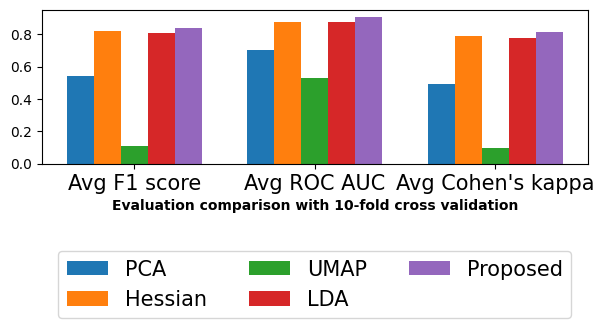

In [ ]:
# Define the evaluation metrics and their values for each method
metrics = [
    "Avg F1 score",
    "Avg ROC AUC",
    "Avg Cohen's kappa",
]

# Set the positions and width of the bars
pos = np.arange(len(metrics))
width = 0.15

# Plot the bars for each method and evaluation metric
fig, ax = plt.subplots(figsize=(6.25, 4.25))  # Adjust the figure width as needed
plt.bar(pos - 2 * width, cov_values[2:], width, label="PCA")
plt.bar(pos - width, hessian_values[2:], width, label="Hessian")
plt.bar(pos, umap_values[2:], width, label="UMAP")
plt.bar(pos + width, lda_values[2:], width, label="LDA")
plt.bar(pos + 2 * width, proposed_values[2:], width, label="Proposed")


# plt.ylabel("Values", fontweight="bold")
plt.xticks(pos, metrics, fontsize=15)

# Add xticks on the middle of the group bars
plt.xlabel(
    "Evaluation comparison with 10-fold cross validation", fontweight="bold"
)

# Move the legend to the bottom and display in a single line
plt.legend(bbox_to_anchor=(0.5, -0.5), loc="upper center", ncol=3, fontsize=15)

plt.tight_layout()  # Adjust the layout to avoid overlapping elements
plt.show()

#### <font color=#FF5F1F><b>Figure T</b></font>

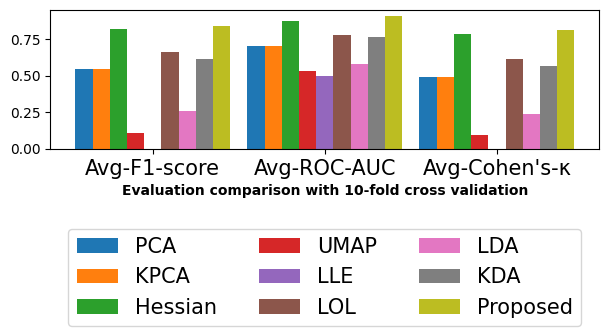

In [ ]:
# Define the evaluation metrics and their values for each method
metrics = [
    "Avg-F1-score",
    "Avg-ROC-AUC",
    "Avg-Cohen's-κ",
]

# Set the positions and width of the bars
pos = np.arange(len(metrics))
width = 0.1

# Plot the bars for each method and evaluation metric
fig, ax = plt.subplots(figsize=(6.25, 4.5))  # Adjust the figure width as needed
plt.bar(pos - 4 * width, pca_values[2:], width, label="PCA")
plt.bar(pos - 3 * width, kpca_values[2:], width, label="KPCA")
plt.bar(pos - 2 * width, hessian_values[2:], width, label="Hessian")
plt.bar(pos - 1 * width, umap_values[2:], width, label="UMAP")
plt.bar(pos, lle_values[2:], width, label="LLE")
plt.bar(pos + 1 * width, lol_values[2:], width, label="LOL")
plt.bar(pos + 2 * width, llda_values[2:], width, label="LDA")
plt.bar(pos + 3 * width, klda_values[2:], width, label="KDA")
plt.bar(pos + 4 * width, proposed_values[2:], width, label="Proposed")


# plt.ylabel("Values", fontweight="bold")
plt.xticks(pos, metrics, fontsize=15)

# Add xticks on the middle of the group bars
plt.xlabel(
    "Evaluation comparison with 10-fold cross validation", fontweight="bold"
)

# Move the legend to the bottom and display in a single line
plt.legend(bbox_to_anchor=(0.5, -0.5), loc="upper center", ncol=3, fontsize=15)

plt.tight_layout()  # Adjust the layout to avoid overlapping elements
plt.show()